#### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import numpy as np
#import scanpy as sc
from sklearn.preprocessing import LabelEncoder
import matplotlib.cm as cmx
import scanpy.external as sce
import itertools
import scipy as sp
from scipy.stats import mannwhitneyu
from scipy import stats
import statsmodels.api
import seaborn as sns
import scanpy as sc
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from adjustText import adjust_text
%load_ext autoreload
%autoreload 2
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt
from gseapy import Biomart
bm = Biomart()
# simple plotting function
from gseapy import barplot, dotplot

#### Read in files

In [73]:
pg_matrix = pd.read_table(r'C:\\Users\\momenzadeha\\Documents\cell_store\report2.pg_matrix.tsv')

In [74]:
gene_prot_map = pd.read_excel(r'C:\\Users\\momenzadeha\\Documents\cell_store\idmapping_cellstore.xlsx')

In [75]:
gene_prot_map=gene_prot_map.rename({'From':'Protein.Ids'},axis=1)

In [76]:
pg_gene_matrix=gene_prot_map.merge(pg_matrix, how='inner',on='Protein.Ids')

In [77]:
pg_gene_matrix.drop(['Protein.Names','Protein.Ids','First.Protein.Description','Protein.Group','Genes'],inplace=True,axis=1)

In [78]:
# fill Na's with zero
pg_gene_matrix.fillna(0, inplace=True)

In [79]:
pg_gene_matrix.reset_index(drop=True, inplace=True)

#### Pre-processing

In [80]:
cols_37 = [col for col in pg_gene_matrix.columns if '_37C' in col]
cols_80 = [col for col in pg_gene_matrix.columns if '_80' in col]
cols_4 = [col for col in pg_gene_matrix.columns if '_4C' in col]

In [81]:
pg_gene_matrix=pg_gene_matrix.rename({'Gene Names (primary)':'Genes'},axis=1)

In [82]:
pg_gene_matrix=pg_gene_matrix.set_index('Genes').T

In [83]:
_37C_df=pg_gene_matrix.loc[cols_37]

In [84]:
_80_df=pg_gene_matrix.loc[cols_80]

In [85]:
_4C_df=pg_gene_matrix.loc[cols_4]

In [86]:
label_gene=pd.concat([_37C_df,_80_df,_4C_df])

In [87]:
# extract column names
_37_column_names = [x for x in label_gene.T.columns if "_37C" in x] 
_80_column_names = [x for x in label_gene.T.columns if "_80" in x]
_4_column_names = [x for x in label_gene.T.columns if "_4C" in x]

In [88]:
len(_37_column_names)

60

In [89]:
len(_80_column_names)

68

In [90]:
len(_4_column_names)

61

#### Make anndata

In [91]:
_37C_df=pg_gene_matrix.loc[cols_37].assign(Group='37C')

In [92]:
_80_df=pg_gene_matrix.loc[cols_80].assign(Group='-80C')

In [93]:
_4C_df=pg_gene_matrix.loc[cols_4].assign(Group='4C')

In [94]:
label_gene=pd.concat([_37C_df,_80_df,_4C_df])

In [95]:
data = ad.AnnData(label_gene.iloc[:,:-1])
data.obs["group"] = label_gene["Group"]

C:\Users\momenzadeha\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [96]:
sc.pp.calculate_qc_metrics(data, inplace=True)

C:\Users\momenzadeha\Anaconda3\lib\site-packages\scanpy\preprocessing\_qc.py:422: RuntimeWarning: invalid value encountered in divide
  return values / sums[:, None]


In [97]:
data.to_df().to_csv('pscs_cell_store_prot.csv')

In [98]:
data.obs.to_csv('pscs_cell_store_obs.csv')

#### Boxplot before normalization

In [28]:
ann_37C=data.to_df().loc[cols_37]

In [29]:
ann_37C=pd.melt(ann_37C.T, value_vars=ann_37C.T.columns)

In [30]:
ann_37C = ann_37C[ann_37C['value'] != 0]

In [31]:
ann_80C=data.to_df().loc[cols_80]

In [32]:
ann_80C=pd.melt(ann_80C.T, value_vars=ann_80C.T.columns)

In [33]:
ann_80C = ann_80C[ann_80C['value'] != 0]

In [34]:
ann_4C=data.to_df().loc[cols_4]

In [35]:
ann_4C=pd.melt(ann_4C.T, value_vars=ann_4C.T.columns)

In [36]:
ann_4C = ann_4C[ann_4C['value'] != 0]

In [37]:
ann_37C['value']=np.log2(ann_37C['value'])

In [38]:
ann_80C['value']=np.log2(ann_80C['value'])

In [39]:
ann_4C['value']=np.log2(ann_4C['value'])

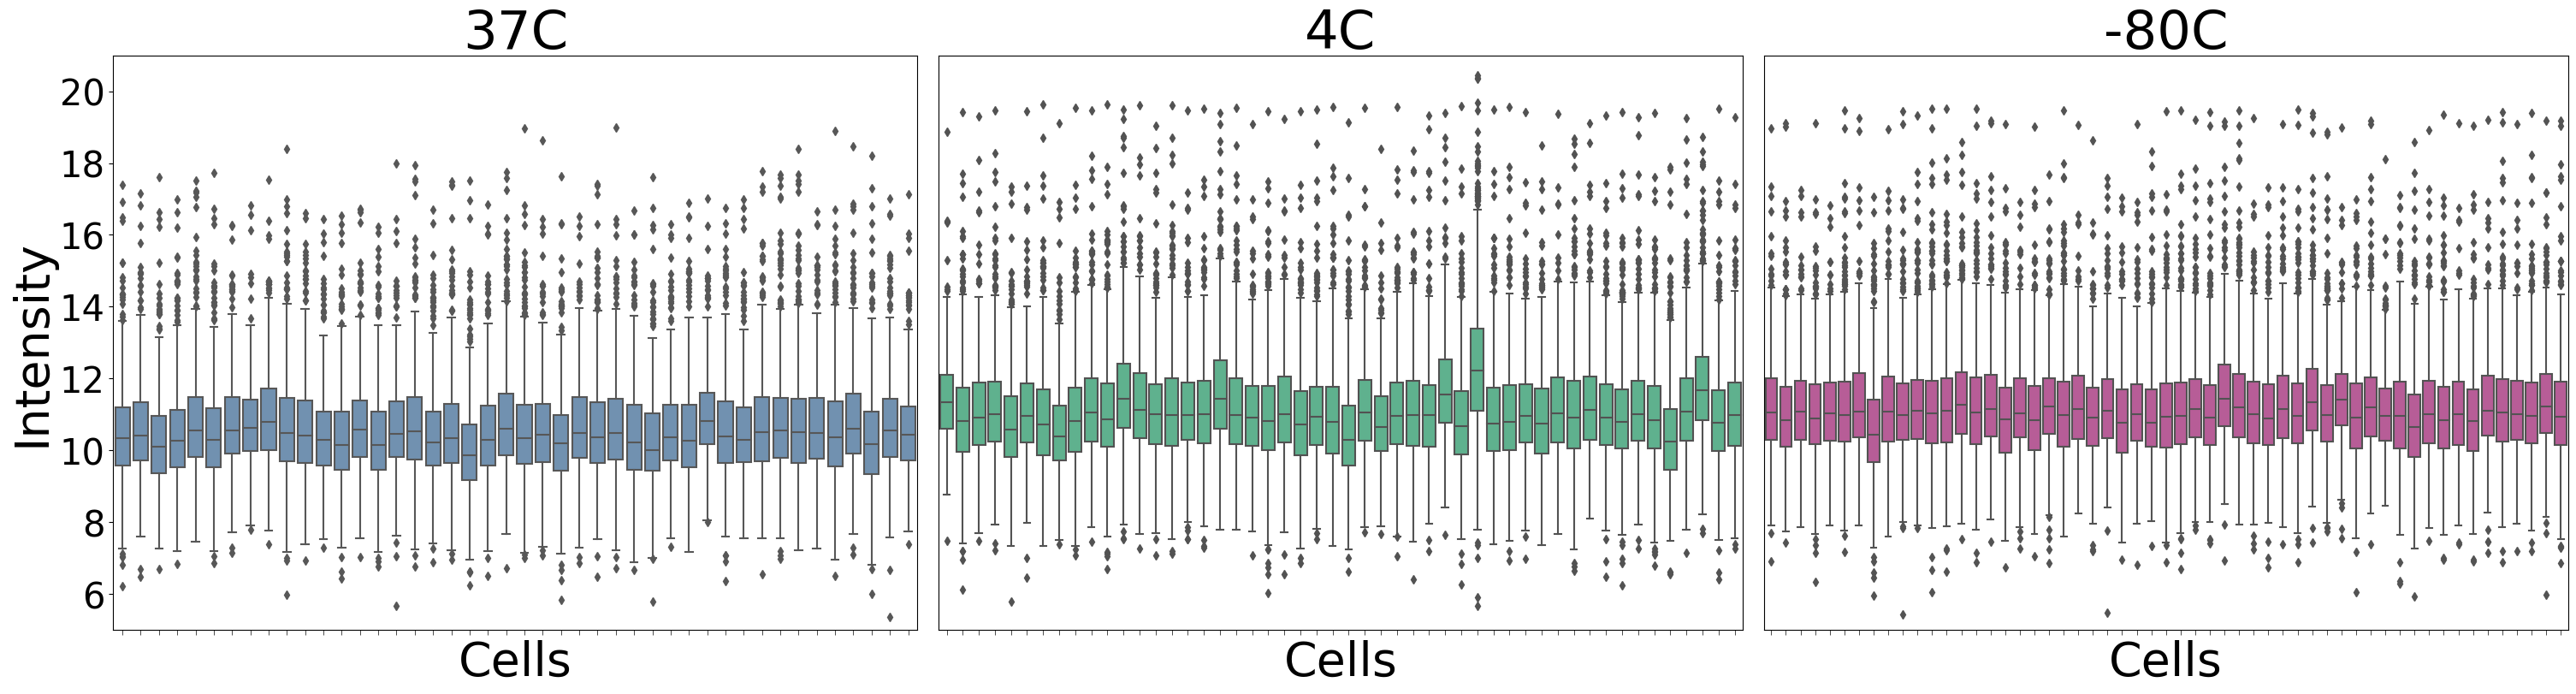

In [40]:
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 

fig, axes = plt.subplots(1,3, figsize=(30,8),constrained_layout=True)

ax1=sns.boxplot(ann_37C, x='variable',y='value',ax=axes[0],color='#6791BA')
axes[0].set_title('37C',fontsize=45)
ax1.tick_params(axis='x',width=0.5, length=4)
ax1.tick_params(labelbottom=False)
ax1.set_ylim(5,21)
ax1.set_xlabel('Cells', fontsize =40)
ax1.set_ylabel('Intensity', fontsize = 40)
axes[0].grid(False) 

ax4=sns.boxplot(ann_4C, x='variable',y='value',ax=axes[1],color='#51BF90')
axes[1].set_title('4C',fontsize=45)
ax4.tick_params(axis='x',width=0.5, length=4)
ax4.tick_params(labelbottom=False)
ax4.set_ylim(5,21)
ax4.set_xlabel('Cells', fontsize = 40)
ax4.axes.get_yaxis().set_visible(False)
axes[1].grid(False) 

ax3=sns.boxplot(ann_80C, x='variable',y='value',ax=axes[2],color='#C64E9C')
axes[2].set_title('-80C',fontsize=45)
ax3.tick_params(axis='x',width=0.5, length=4)
ax3.tick_params(labelbottom=False)
ax3.set_ylim(5,21)
ax3.set_xlabel('Cells', fontsize = 40)
ax3.axes.get_yaxis().set_visible(False)
axes[2].grid(False) 
plt.savefig('figures/SF1.svg',bbox_inches='tight')
plt.show()

In [41]:
mean_int_list=(ann_37C.groupby(['variable']).mean()['value'].values).tolist() + (ann_4C.groupby(['variable']).mean()['value'].values).tolist() + (ann_80C.groupby(['variable']).mean()['value'].values).tolist()

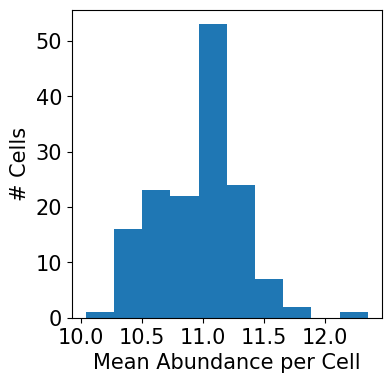

In [43]:
fig = plt.figure(figsize=(4,4))
plt.rcParams.update(plt.rcParamsDefault)
plt.hist(mean_int_list)
plt.xlabel('Mean Abundance per Cell',fontsize=15)
plt.ylabel('# Cells',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#### Filter and normalize

In [99]:
data.to_df().shape

(189, 1806)

In [100]:
sc.pp.filter_cells(data, min_genes=200)
sc.pp.filter_genes(data, min_cells=10)

C:\Users\momenzadeha\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\momenzadeha\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [101]:
cols_37 = [col for col in data.to_df().T.columns if '_37C' in col]
cols_80 = [col for col in data.to_df().T.columns if '_80' in col]
cols_4 = [col for col in data.to_df().T.columns if '_4C' in col]

##### histograms prior to norm

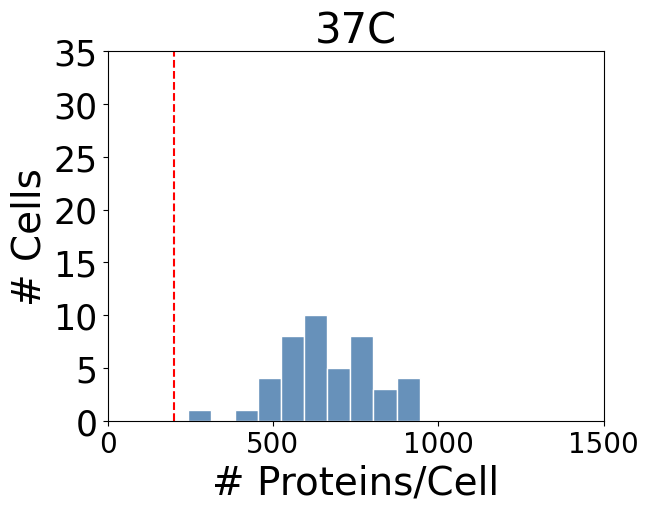

In [47]:
plt.hist(data.to_df().T[cols_37][data.to_df().T[cols_37]>0].count(),
         edgecolor="white",color='#6791BA')
plt.xlabel('# Proteins/Cell',fontsize=28)
plt.ylabel('# Cells',fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
plt.axvline(x=200, color='r', linestyle='--')
plt.title('37C',fontsize=30)
plt.xlim(0,1200)
plt.ylim(0,35)
plt.grid(False)
x_interval = 500
y_interval = 5

# Generate ticks for x and y axes
x_ticks = np.arange(0, 1200 + x_interval, x_interval)
y_ticks = np.arange(0, 35 + y_interval, y_interval)

# Set the ticks on the plot
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.grid(False)
plt.savefig('figures/Fig1C_37C.svg',bbox_inches='tight')
plt.show()

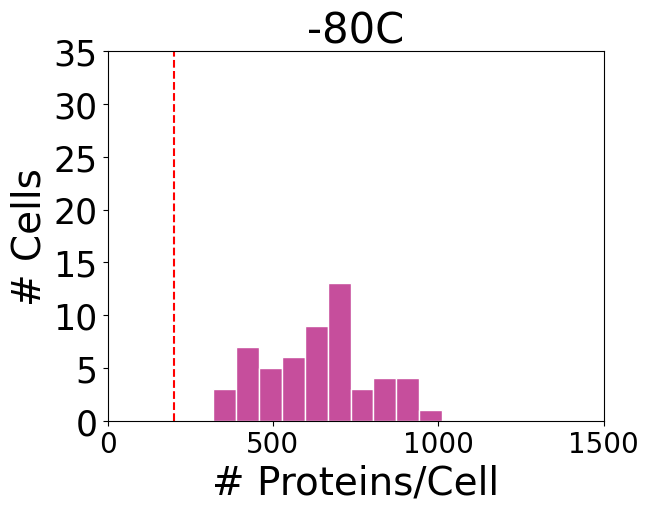

In [48]:
plt.hist(data.to_df().T[cols_80][data.to_df().T[cols_80]>0].count(),
         edgecolor='white',color='#C64E9C')
plt.xlabel('# Proteins/Cell',fontsize=28)
plt.ylabel('# Cells',fontsize=28)
plt.axvline(x=200, color='r', linestyle='--')
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
plt.title('-80C',fontsize=30)
plt.xlim(0,1200)
plt.ylim(0,35)
plt.grid(False)
x_interval = 500
y_interval = 5

# Generate ticks for x and y axes
x_ticks = np.arange(0, 1200 + x_interval, x_interval)
y_ticks = np.arange(0, 35 + y_interval, y_interval)

# Set the ticks on the plot
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.grid(False)
plt.savefig('figures/Fig1C_80C.svg',bbox_inches='tight')
plt.show()

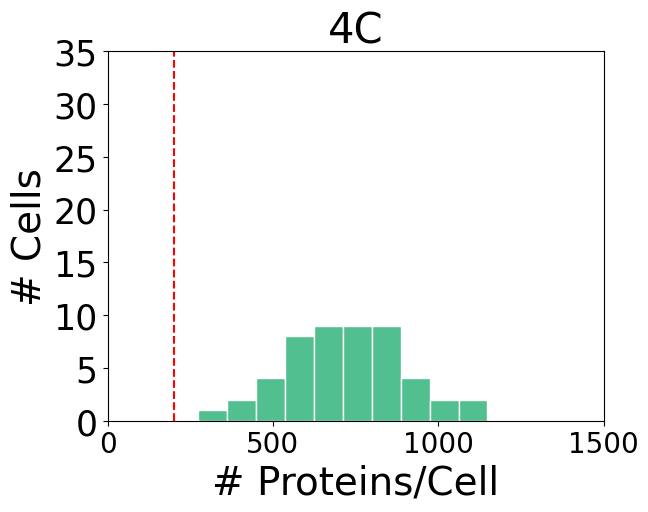

In [49]:
plt.hist(data.to_df().T[cols_4][data.to_df().T[cols_4]>0].count(),
         edgecolor='white',color='#51BF90')
plt.xlabel('# Proteins/Cell',fontsize=28)
plt.ylabel('# Cells',fontsize=28)
plt.axvline(x=200, color='r', linestyle='--')
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
plt.xlim(0,1200)
plt.ylim(0,35)
plt.grid(False)
x_interval = 500
y_interval = 5

# Generate ticks for x and y axes
x_ticks = np.arange(0, 1200 + x_interval, x_interval)
y_ticks = np.arange(0, 35 + y_interval, y_interval)

# Set the ticks on the plot
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.title('4C',fontsize=30)
plt.grid(False)
plt.savefig('figures/Fig1C_4C.svg',bbox_inches='tight')
plt.show()

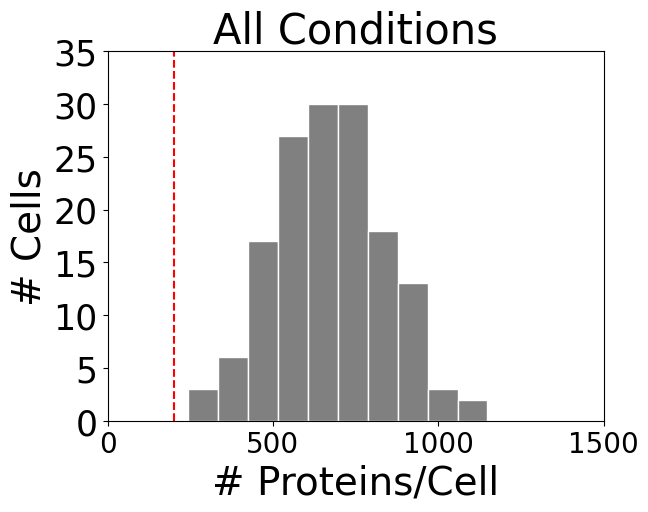

In [50]:
plt.hist(data.to_df().T[data.to_df().T>0].count(),edgecolor='white',color='grey')
plt.xlabel('# Proteins/Cell',fontsize=28)
plt.ylabel('# Cells',fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
plt.axvline(x=200, color='r', linestyle='--')
plt.xlim(0,1200)
plt.ylim(0,35)
plt.grid(False)
x_interval = 500
y_interval = 5

# Generate ticks for x and y axes
x_ticks = np.arange(0, 1200 + x_interval, x_interval)
y_ticks = np.arange(0, 35 + y_interval, y_interval)

# Set the ticks on the plot
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.title('All Conditions',fontsize=30)
plt.savefig('figures/Fig1C_all.svg',bbox_inches='tight')
plt.show()

In [55]:
group1 = data.to_df().T[cols_4][data.to_df().T[cols_4]>0].count().values
group2 = data.to_df().T[cols_37][data.to_df().T[cols_37]>0].count().values
group3 = data.to_df().T[cols_80][data.to_df().T[cols_80]>0].count().values
# Perform one-way ANOVA
f_statistic, p_value = f_oneway(group1, group2, group3)
print("p-value:", p_value)

p-value: 0.02179171963048534


##### normalization

In [102]:
sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)
sc.pp.regress_out(data, ['total_counts'])
sc.pp.scale(data, max_value=10)

In [103]:
ss = StandardScaler()
data.X = ss.fit_transform(data.to_df().T).T

##### boxplot after filtering

In [58]:
ann_37C=data.to_df().loc[cols_37]

In [59]:
ann_37C=pd.melt(ann_37C.T, value_vars=ann_37C.T.columns)

In [60]:
ann_37C = ann_37C[ann_37C['value'] != 0]

In [61]:
ann_80C=data.to_df().loc[cols_80]

In [62]:
ann_80C=pd.melt(ann_80C.T, value_vars=ann_80C.T.columns)

In [63]:
ann_80C = ann_80C[ann_80C['value'] != 0]

In [64]:
ann_4C=data.to_df().loc[cols_4]

In [65]:
ann_4C=pd.melt(ann_4C.T, value_vars=ann_4C.T.columns)

In [66]:
ann_4C = ann_4C[ann_4C['value'] != 0]

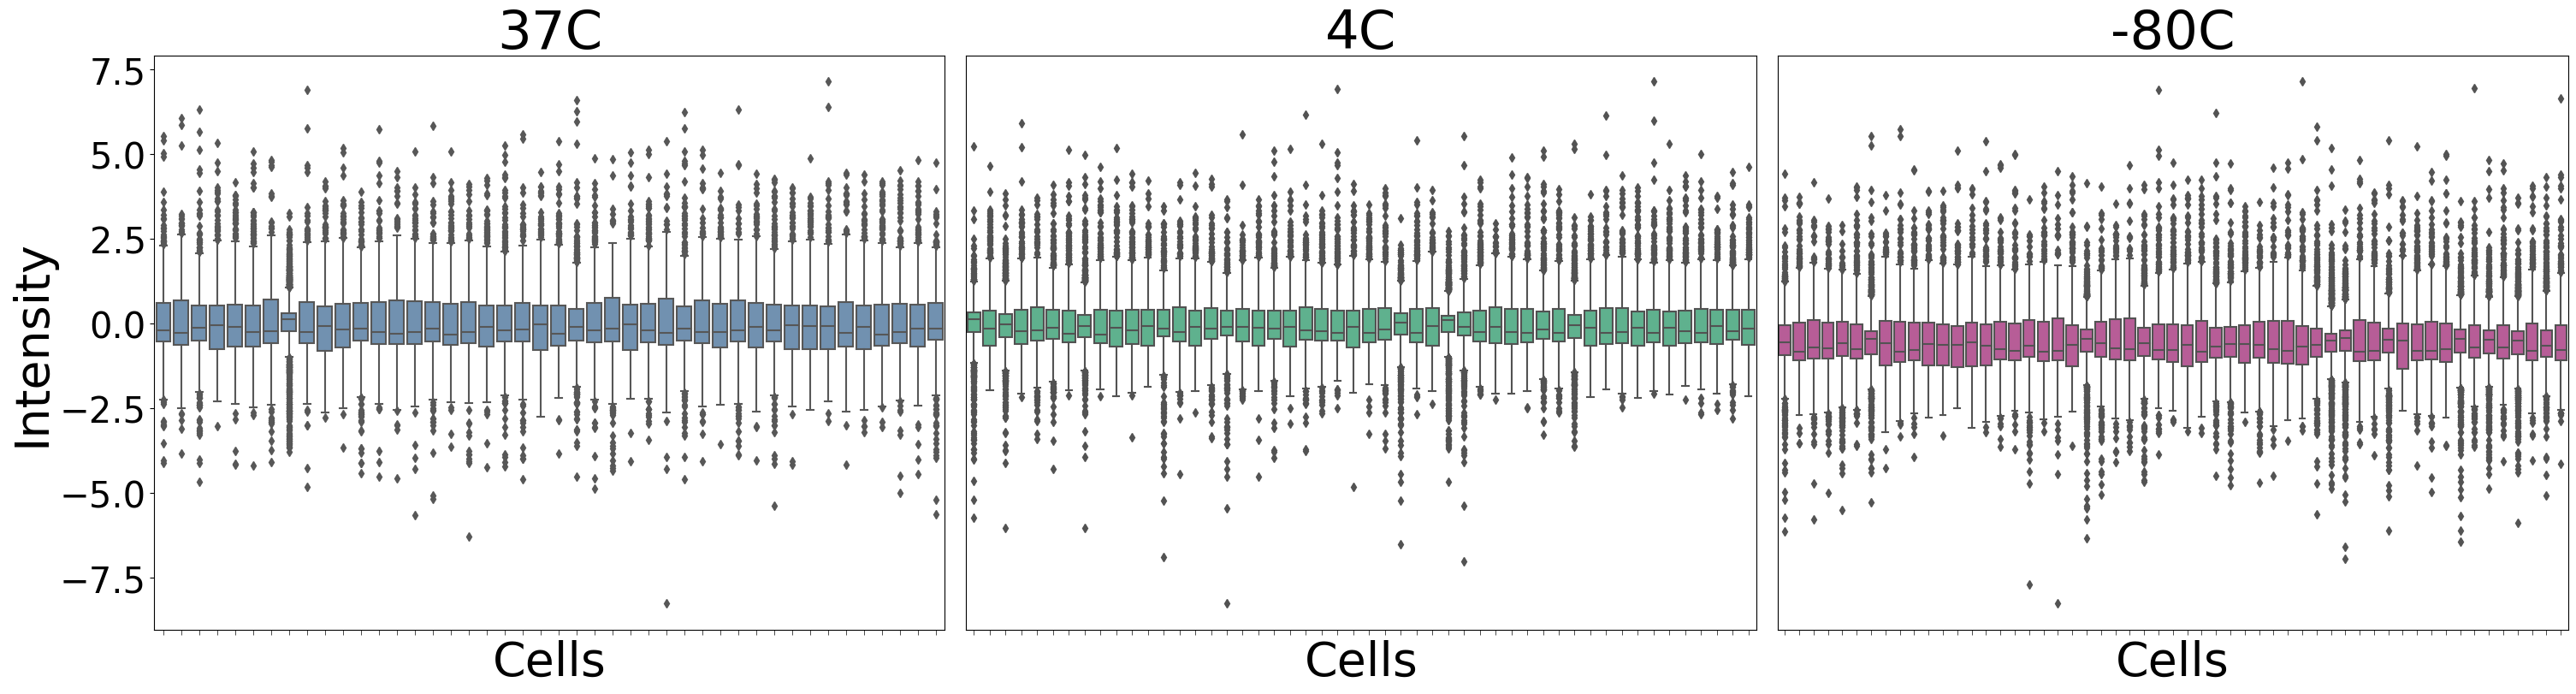

In [67]:
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 

fig, axes = plt.subplots(1,3, figsize=(30,8),constrained_layout=True)

ax1=sns.boxplot(ann_37C, x='variable',y='value',ax=axes[0],color='#6791BA')
axes[0].set_title('37C',fontsize=45)
ax1.tick_params(axis='x',width=0.5, length=4)
ax1.tick_params(labelbottom=False)
ax1.set_xlabel('Cells', fontsize =40)
ax1.set_ylabel('Intensity', fontsize = 40)

ax4=sns.boxplot(ann_4C, x='variable',y='value',ax=axes[1],color='#51BF90')
axes[1].set_title('4C',fontsize=45)
ax4.tick_params(axis='x',width=0.5, length=4)
ax4.tick_params(labelbottom=False)
#ax4.set_ylim(5,21)
ax4.set_xlabel('Cells', fontsize = 40)
ax4.axes.get_yaxis().set_visible(False)

ax3=sns.boxplot(ann_80C, x='variable',y='value',ax=axes[2],color='#C64E9C')
axes[2].set_title('-80C',fontsize=45)
ax3.tick_params(axis='x',width=0.5, length=4)
ax3.tick_params(labelbottom=False)
ax3.set_xlabel('Cells', fontsize = 40)
ax3.axes.get_yaxis().set_visible(False)

plt.savefig('figures/Fig1D.svg',bbox_inches='tight')
plt.show()

#### UMAP

In [68]:
sc.tl.pca(data, svd_solver='arpack')

In [69]:
sc.pp.neighbors(data)
sc.tl.umap(data,random_state=0)
sc.tl.leiden(data, resolution=0.1)

In [70]:
sc.pp.calculate_qc_metrics(data, inplace=True)

C:\Users\momenzadeha\Anaconda3\lib\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [71]:
data.to_df().to_csv('cell_store_SC_norm_genes.csv')

In [72]:
data.obs.to_csv('cell_store_SC_norm_meta.csv')

In [73]:
sc.set_figure_params(scanpy=True, fontsize=25)

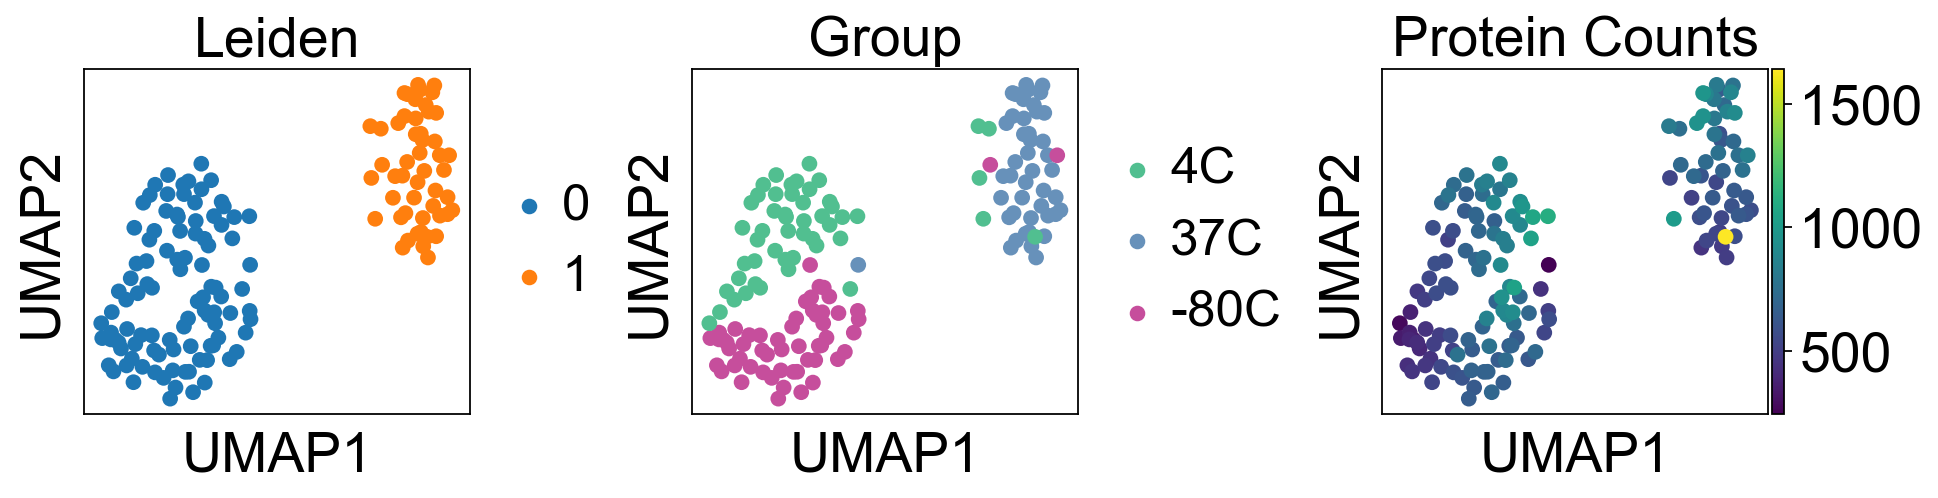

In [74]:
fig, axs = plt.subplots(1,3, figsize=(12,3),constrained_layout=True)
sc.pl.umap(data, color=['leiden'],title="Leiden", ax=axs[0], show=False, s=200, use_raw=False)
sc.pl.umap(data, color=['group'],title="Group", ax=axs[1], palette=['#51BF90','#6791BA','#C64E9C'],show=False,s=200,use_raw=False)
sc.pl.umap(data, color=['n_genes'],title="Protein Counts", ax=axs[2], show=False,s=200,use_raw=False)
plt.savefig('figures/Fig2A.svg',bbox_inches='tight')
plt.show()

In [75]:
tc_norm=data.to_df()

In [76]:
cols_37 = [col for col in tc_norm.T.columns if '_37C' in col]
cols_80 = [col for col in tc_norm.T.columns if '_80' in col]
cols_4 = [col for col in tc_norm.T.columns if '_4C' in col]

In [77]:
d = {
    '4C': np.asarray(tc_norm.loc[cols_4]),  
    '37C': np.asarray(tc_norm.loc[cols_37]),  
    '-80C': np.asarray(tc_norm.loc[cols_80])
}

# Calculate the centroids of each group
centroids = {group: np.mean(points, axis=0) for group, points in d.items()}

# Calculate distances between the centroids of each group
centroid_distances = {}
for group1, centroid1 in centroids.items():
    for group2, centroid2 in centroids.items():
        if group1 < group2:  # This condition avoids duplicate pairs and self-pairing
            distance = euclidean(centroid1, centroid2)
            centroid_distances[(group1, group2)] = distance

# Display the distances
for groups, distance in centroid_distances.items():
    print(f"Distance between {groups[0]} and {groups[1]}: {distance:.4f}")


Distance between 37C and 4C: 19.5021
Distance between -80C and 4C: 13.7286
Distance between -80C and 37C: 21.9856


####  DE gene testing

In [82]:
def batch_mean(geno_leid,batch_list,ann_df):
    tmplist = []
    for x in batch_list:
        geno_leid_batch=geno_leid[(geno_leid['batch'] == x)]
        geno_leid_batch_mean=ann_df.to_df().loc[geno_leid_batch.index].mean()
        geno_leid_batch_mean_df=pd.DataFrame(geno_leid_batch_mean).rename(columns={0:'value'})
        tmplist.append(geno_leid_batch_mean_df)
    geno_concat=pd.concat(tmplist, axis=0)
    geno_concat.dropna(inplace=True)
    return geno_concat

In [83]:
_4C=data.to_df().loc[data.obs[(data.obs['group'] == '4C')].index]

In [84]:
_4C=pd.DataFrame(_4C).rename(columns={0:'value'}).T.reset_index()

In [85]:
_4C_melt=_4C.melt(id_vars=['Genes'], value_vars=_4C.iloc[2:,:].columns.tolist()).assign(Group='4C')

In [86]:
_37C=data.to_df().loc[data.obs[(data.obs['group'] == '37C')].index]

In [87]:
_37C=pd.DataFrame(_37C).rename(columns={0:'value'}).T.reset_index()

In [88]:
_37C_melt=_37C.melt(id_vars=['Genes'], value_vars=_37C.iloc[2:,:].columns.tolist()).assign(Group='37C')

In [89]:
_80C=data.to_df().loc[data.obs[(data.obs['group'] == '-80C')].index]

In [90]:
_80C=pd.DataFrame(_80C).rename(columns={0:'value'}).T.reset_index()

In [91]:
_80C_melt=_80C.melt(id_vars=['Genes'], value_vars=_80C.iloc[2:,:].columns.tolist()).assign(Group='-80C')

In [92]:
concat_cond=pd.concat([_4C_melt,_37C_melt,_80C_melt])

In [93]:
concat_cond=concat_cond.reset_index()

##### 37C vs 4C

In [94]:
def Average(lst): 
    return sum(lst) / len(lst) if lst else np.nan  # Return NaN if the list is empty

pvalues = []
protein_names = []
i = 0
_4C_mean = []
_37C_mean = []

for x in concat_cond['Genes'].unique():
    tempdf = concat_cond[concat_cond.isin([x]).any(axis=1)]
    
    # Filter out zero values
    coh1_values = [value for value in tempdf[(tempdf.Group == '4C')]['value'].tolist() if value != 0]
    coh2_values = [value for value in tempdf[(tempdf.Group == '37C')]['value'].tolist() if value != 0]
    
    _4C_mean.append(Average(coh1_values))
    _37C_mean.append(Average(coh2_values))
    
    if np.any(((len(coh1_values) < 4), (len(coh2_values) < 4))):
        pvalues.append(np.nan)
        protein_names.append(x)
    else:
        test = list(itertools.chain([coh1_values], [coh2_values]))
        t_val, p_val = stats.ttest_ind(*test)
        pvalues.append(p_val)
        protein_names.append(x)
    
    i += 1
    if i % 100 == 0: 
        print(i)

100
200
300
400
500
600
700
800
900
1000
1100
1200


###### BH 

In [95]:
pval_df= pd.DataFrame({'genes': protein_names,'37C_mean':_37C_mean,'4C_mean':_4C_mean,'pvals': pvalues})

In [96]:
pval_df.dropna(inplace=True)
y = statsmodels.stats.multitest.multipletests(pvals=pval_df['pvals'].values, alpha=0.05, method="fdr_bh")
pval_df['adj_pval']=list(y[1])
pval_df_nona=pval_df.dropna()

In [97]:
pval_df_nona['37C-4C_LogFC']=pval_df_nona['37C_mean']-pval_df_nona['4C_mean']

In [98]:
pval_df_nona['neg_log10_adj_pval']=np.log10(pval_df_nona['adj_pval']) * (-1)

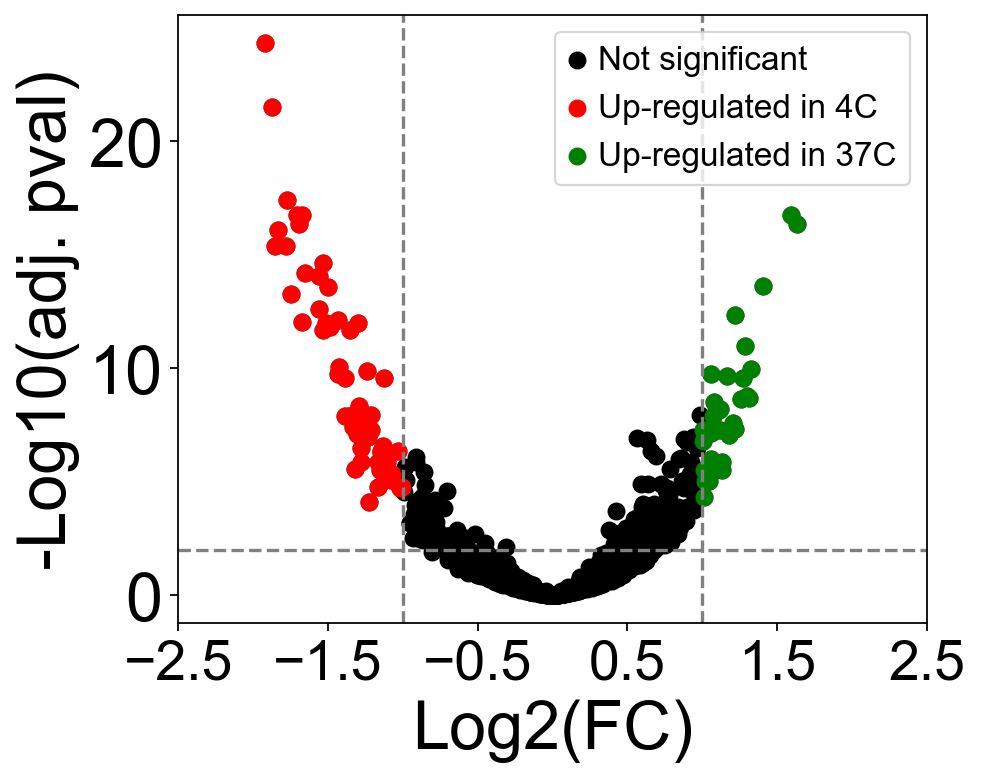

In [ ]:
plt.figure(figsize=(6,5))

plt.scatter(x=pval_df_nona.set_index('genes')['37C-4C_LogFC'], y=pval_df_nona.set_index('genes')
            ['adj_pval'].apply(lambda x:-np.log10(x)), s=50,label="Not significant", color='black')

down = pval_df_nona.set_index('genes')[(pval_df_nona.set_index('genes')
                                        ['37C-4C_LogFC']<-1)&(pval_df_nona.set_index('genes')['adj_pval']<=0.01)]
up = pval_df_nona.set_index('genes')[(pval_df_nona.set_index('genes')
                                      ['37C-4C_LogFC']>=1)&(pval_df_nona.set_index('genes')['adj_pval']<=0.01)]

plt.scatter(x=down['37C-4C_LogFC'],y=down['adj_pval'].apply(lambda x:-np.log10(x)),s=50,label="Up-regulated in 4C",color="red")
plt.scatter(x=up['37C-4C_LogFC'],y=up['adj_pval'].apply(lambda x:-np.log10(x)),s=50,label="Up-regulated in 37C",color="green")

#texts=[]
#for i,r in up.iterrows():
    #texts.append(plt.text(x=r['37C-4C_LogFC'],y=-np.log10(r['adj_pval']),s=i,fontsize=15))
#adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.3))
#texts2=[]
#for i,r in down.iterrows():
    #texts2.append(plt.text(x=r['37C-4C_LogFC'],y=-np.log10(r['adj_pval']),s=i,fontsize=15))
#adjust_text(texts2,arrowprops=dict(arrowstyle="-", color='black', lw=0.3))


plt.axvline(1,color="grey",linestyle="--")
plt.axvline(-1,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.xlim(-2.5,2.5)
#plt.ylim(-0.1,8)
plt.legend(fontsize=15)
plt.ylabel("-Log10(adj. pval)", fontsize=30)
plt.xlabel("Log2(FC)", fontsize=30)
plt.xticks(
    fontweight='light',
    fontsize=25  
)
plt.yticks(
    fontweight='light',
    fontsize=30
)
x_interval = 1

# Generate ticks for x and y axes
x_ticks = np.arange(-2.5, 2.5 + x_interval, x_interval)

# Set the ticks on the plot
plt.xticks(x_ticks)
#plt.yticks(y_ticks)
plt.grid(False)
#plt.title('37C vs 4C',fontsize=20)
plt.legend(fontsize=15, markerscale=1,loc='best')
plt.savefig('figures/Fig2B.svg', bbox_inches='tight')
plt.show()

In [ ]:
_37C_up=pval_df_nona[((pval_df_nona['37C-4C_LogFC'])>1) & (pval_df_nona['neg_log10_adj_pval']>2)].assign(Group='upregulated in 37C')

In [ ]:
_4C_up=pval_df_nona[((pval_df_nona['37C-4C_LogFC'])<-1) & (pval_df_nona['neg_log10_adj_pval']>2)].assign(Group='upregulated in 4C')

In [ ]:
_4C_uplist=_4C_up.genes.to_list()

In [ ]:
pd.concat([_4C_up,_37C_up]).Group.value_counts()

upregulated in 4C     64
upregulated in 37C    33
Name: Group, dtype: int64

In [ ]:
_4C_up_tot=pval_df_nona[((pval_df_nona['37C-4C_LogFC'])<0)].assign(Group='pos in 4C')
_37C_up_tot=pval_df_nona[((pval_df_nona['37C-4C_LogFC'])>0)].assign(Group='pos in 37')
pd.concat([_4C_up_tot,_37C_up_tot]).Group.value_counts()

pos in 37    663
pos in 4C    605
Name: Group, dtype: int64

In [ ]:
_4_37_DEG=pd.concat([_4C_up,_37C_up])

In [ ]:
_4_37_DEG.to_csv('4C_37C_DEG.csv')

In [ ]:
_4_37_genelist=_4_37_DEG.genes.to_list()

In [ ]:
pval_df_nona.to_csv('4C_37C_all.csv')

##### 37C vs -80C

In [109]:
def Average(lst): 
    return sum(lst) / len(lst) if lst else np.nan  # Return NaN if the list is empty

pvalues = []
protein_names = []
i = 0
_37C_mean = []
_80C_mean = []

for x in concat_cond['Genes'].unique():
    tempdf = concat_cond[concat_cond.isin([x]).any(axis=1)]
    
    # Filter out zero values
    coh1_values = [value for value in tempdf[(tempdf.Group == '-80C')]['value'].tolist() if value != 0]
    coh2_values = [value for value in tempdf[(tempdf.Group == '37C')]['value'].tolist() if value != 0]
    
    _80C_mean.append(Average(coh1_values))
    _37C_mean.append(Average(coh2_values))
    
    if np.any(((len(coh1_values) < 4), (len(coh2_values) < 4))):
        pvalues.append(np.nan)
        protein_names.append(x)
    else:
        test = list(itertools.chain([coh1_values], [coh2_values]))
        t_val, p_val = stats.ttest_ind(*test)
        pvalues.append(p_val)
        protein_names.append(x)
    
    i += 1
    if i % 100 == 0: 
        print(i)

100
200
300
400
500
600
700
800
900
1000
1100
1200


###### BH 

In [110]:
pval_df= pd.DataFrame({'genes': protein_names,'37C_mean':_37C_mean,'-80C_mean':_80C_mean,'pvals': pvalues})

In [111]:
pval_df.dropna(inplace=True)
y = statsmodels.stats.multitest.multipletests(pvals=pval_df['pvals'].values, alpha=0.05, method="fdr_bh")
pval_df['adj_pval']=list(y[1])
pval_df_nona_80=pval_df.dropna()

In [112]:
pval_df_nona_80['37C-80C_LogFC']=pval_df_nona_80['37C_mean']-pval_df_nona_80['-80C_mean']

In [113]:
pval_df_nona_80['neg_log10_adj_pval']=np.log10(pval_df_nona_80['adj_pval']) * (-1)

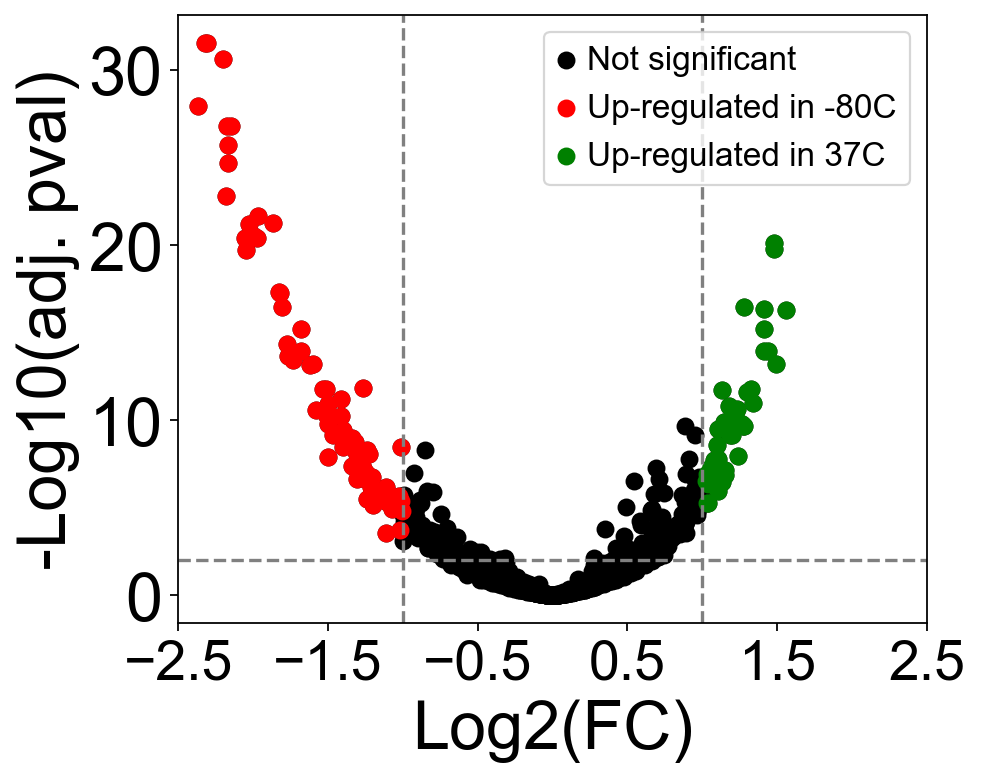

In [114]:
plt.figure(figsize=(6,5))

plt.scatter(x=pval_df_nona_80['37C-80C_LogFC'], y=pval_df_nona_80['adj_pval'].apply(lambda x:-np.log10(x)), 
            s=50,label="Not significant", color='black')

down = pval_df_nona_80[(pval_df_nona_80['37C-80C_LogFC']<-1)&(pval_df_nona_80['adj_pval']<=0.01)]
up = pval_df_nona_80[(pval_df_nona_80['37C-80C_LogFC']>=1)&(pval_df_nona_80['adj_pval']<=0.01)]

plt.scatter(x=down['37C-80C_LogFC'],y=down['adj_pval'].apply(lambda x:-np.log10(x)),s=50,label="Up-regulated in -80C",color="red")
plt.scatter(x=up['37C-80C_LogFC'],y=up['adj_pval'].apply(lambda x:-np.log10(x)),s=50,label="Up-regulated in 37C",color="green")

plt.axvline(1,color="grey",linestyle="--")
plt.axvline(-1,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.xlim(-2,2)
#plt.ylim(-0.1,8)
plt.legend(fontsize=15)
plt.ylabel("-Log10(adj. pval)", fontsize=30)
plt.xlabel("Log2(FC)", fontsize=30)
plt.xticks(
    fontweight='light',
    fontsize=25  
)
plt.yticks(
    fontweight='light',
    fontsize=30
)
x_interval = 1

# Generate ticks for x and y axes
x_ticks = np.arange(-2.5, 2.5 + x_interval, x_interval)

# Set the ticks on the plot
plt.xticks(x_ticks)
#plt.yticks(y_ticks)
plt.grid(False)
#plt.title('37C vs 4C',fontsize=20)
plt.legend(fontsize=15, markerscale=1,loc='best')
plt.savefig('figures/Fig2C.svg', bbox_inches='tight')
plt.show()

In [115]:
_37C_up=pval_df_nona_80[((pval_df_nona_80['37C-80C_LogFC'])>1) & (pval_df_nona_80['neg_log10_adj_pval']>2)].assign(Group='upregulated in 37C')

In [116]:
_80C_up=pval_df_nona_80[((pval_df_nona_80['37C-80C_LogFC'])<-1) & (pval_df_nona_80['neg_log10_adj_pval']>2)].assign(Group='upregulated in -80C')

In [117]:
_80C_uplist=_80C_up.genes.to_list()

In [118]:
pd.concat([_80C_up,_37C_up]).Group.value_counts()

upregulated in -80C    74
upregulated in 37C     47
Name: Group, dtype: int64

In [119]:
_80C_combc=pval_df_nona_80[((pval_df_nona_80['37C-80C_LogFC'])<0)].assign(Group='pos in 4C')
_37C_combc=pval_df_nona_80[((pval_df_nona_80['37C-80C_LogFC'])>0)].assign(Group='pos in 37')
pd.concat([_80C_combc,_37C_combc]).Group.value_counts()

pos in 37    684
pos in 4C    584
Name: Group, dtype: int64

In [120]:
_80_37_DEG=pd.concat([_80C_up,_37C_up])

In [121]:
_80_37_genelist=_80_37_DEG.genes.to_list()

In [122]:
_80_37_DEG.to_csv('80C_37C_DEG.csv')

In [123]:
pval_df_nona_80.to_csv('80C_37C_all.csv')

#### Pathway analysis

In [124]:
queries ={'ensembl_gene_id': ['ENSG00000125285','ENSG00000182968'] } # need to be a dict object
results = bm.query(dataset='hsapiens_gene_ensembl',
                   attributes=['ensembl_gene_id', 'external_gene_name', 'entrezgene_id', 'go_id'],
                   filters=queries)
results.tail()
# default: Human
names = gp.get_library_name()
#names[:10]

In [125]:
human_lib = gp.get_library_name(organism='human')

In [126]:
enr = gp.enrichr(gene_list=_4_37_genelist,
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human','GO_Molecular_Function_2023',
                            'GO_Biological_Process_2023','Reactome_2022'],
                 organism='human', 
                 outdir=None)

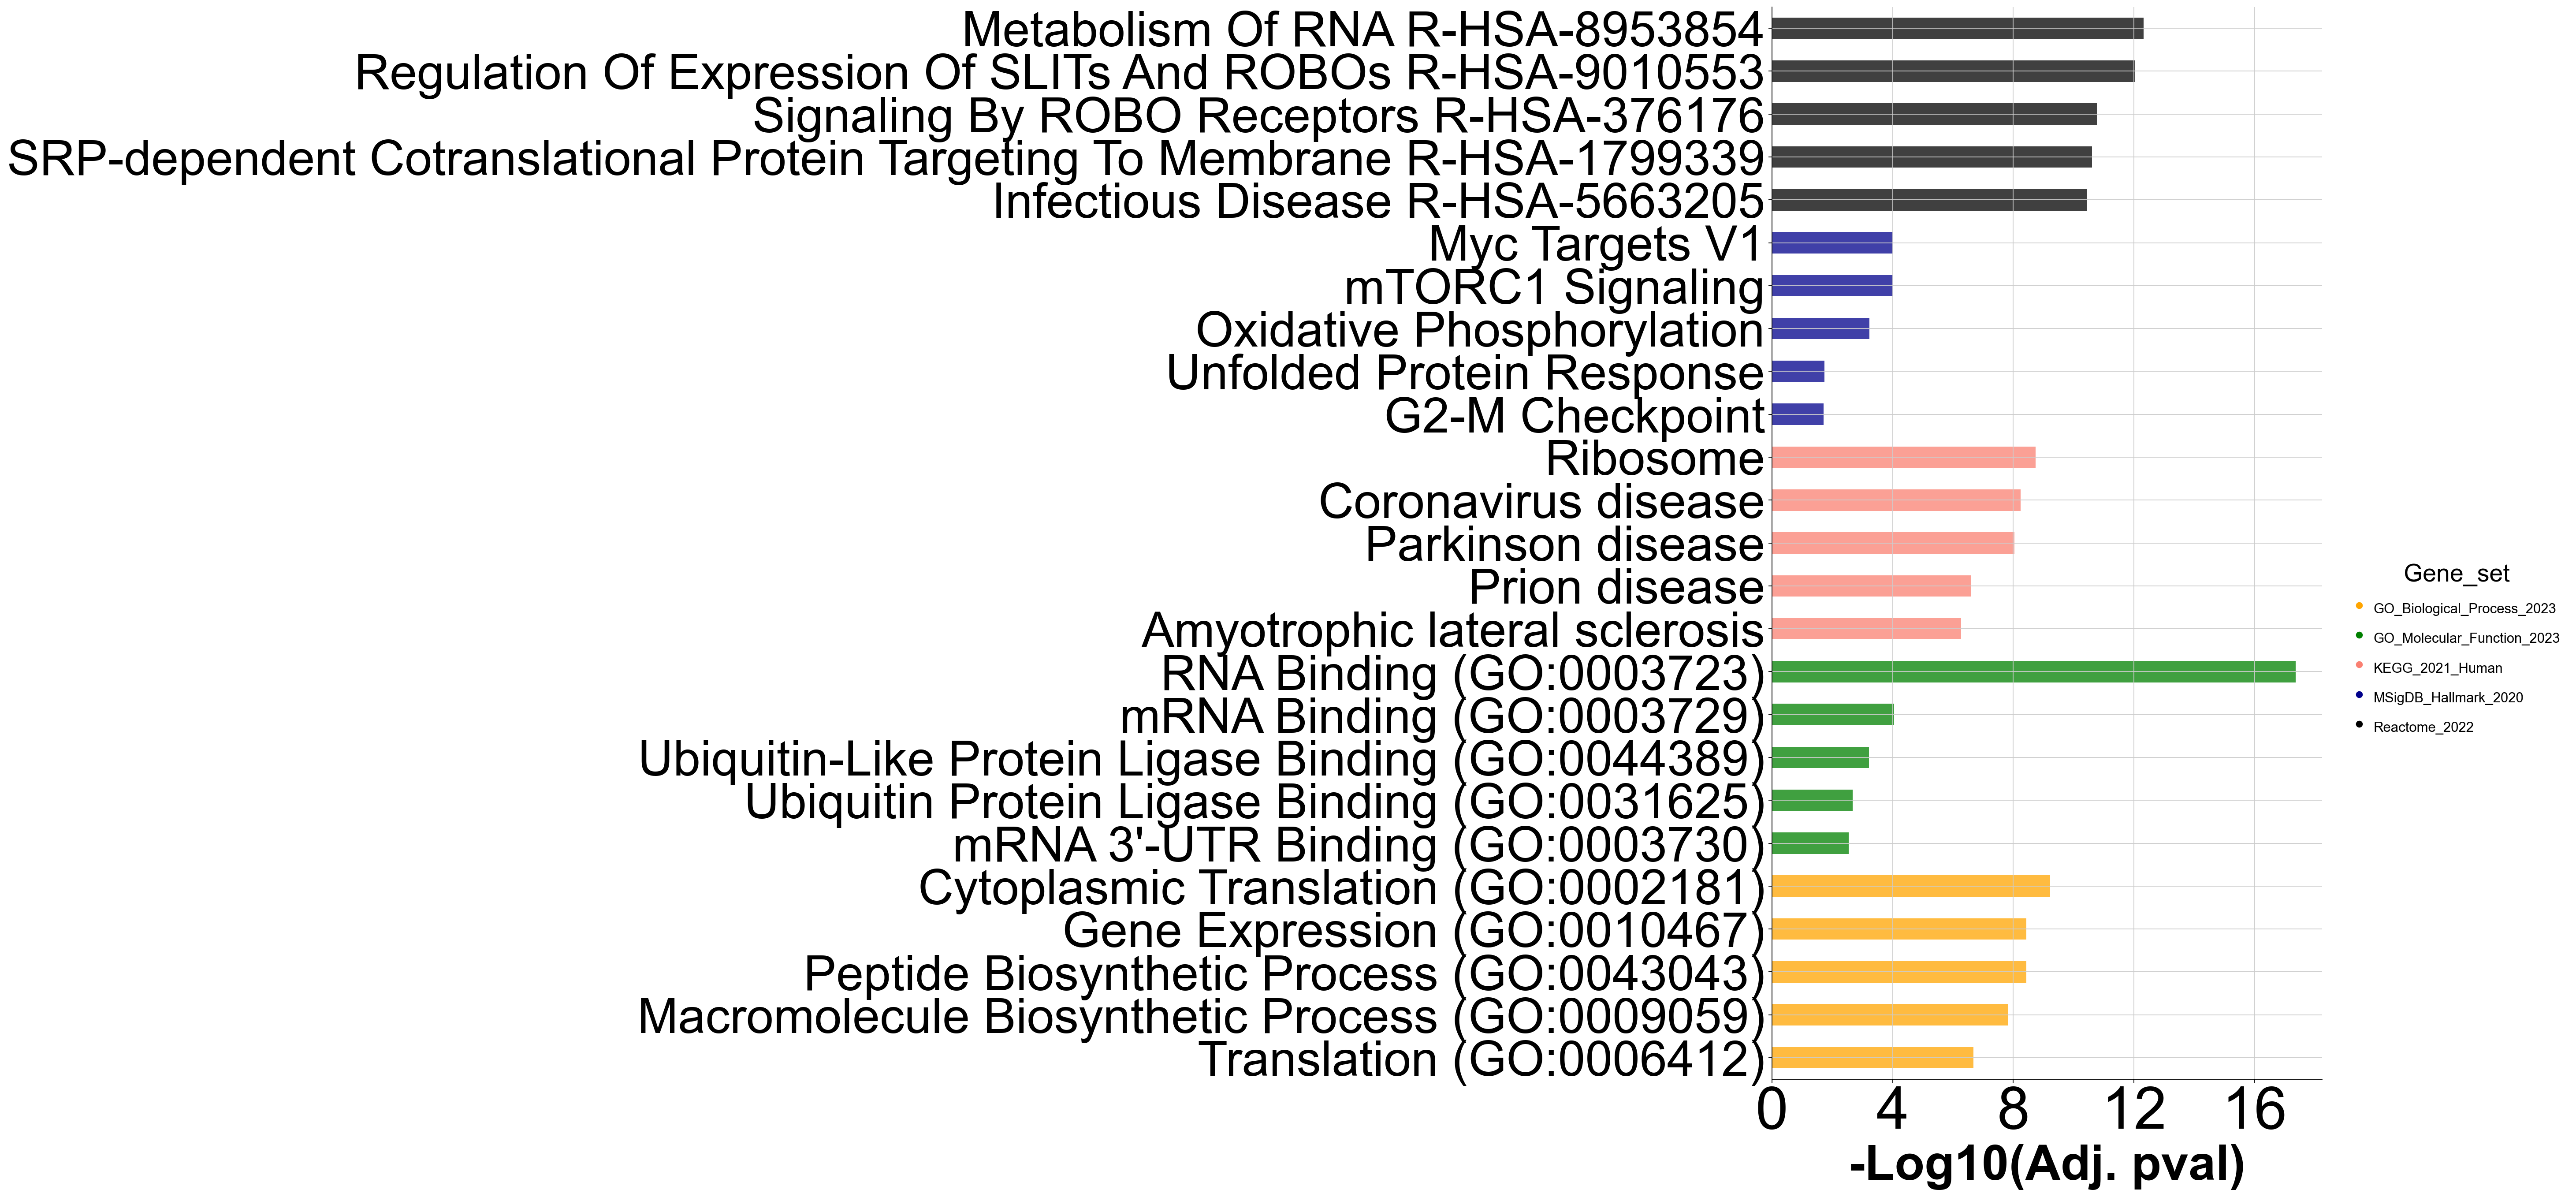

In [127]:
plt.rcParams.update({
    'axes.labelsize': 50,  
    'xtick.labelsize': 70, 
    'ytick.labelsize': 50})

ax = barplot(
    enr.results,
    column="Adjusted P-value",
    group='Gene_set', 
    size=50,
    top_term=5,
    figsize=(10, 20),
    color={
        'KEGG_2021_Human': 'salmon',
        'MSigDB_Hallmark_2020': 'darkblue',
        'GO_Molecular_Function_2023': 'green',
        'GO_Biological_Process_2023': 'orange',
        'Reactome_2022': 'black'})

ax.set_xlabel('-Log10(Adj. pval)', fontsize=50)
for tick in ax.get_xticklabels():
    tick.set_fontsize(60)
for tick in ax.get_yticklabels():
    tick.set_fontsize(50)
legend = ax.get_legend()
if legend:
    for text in legend.get_texts():
        text.set_fontsize(14)
plt.savefig('figures/4C_pathway.svg',bbox_inches='tight')
plt.show()

In [128]:
enr.results['neg_log10(adj.pval)']=-1*np.log10(enr.results['Adjusted P-value'])

In [129]:
top_5_per_set = enr.results.groupby('Gene_set').apply(lambda x: x.nlargest(5, 'neg_log10(adj.pval)')).reset_index(drop=True)

In [130]:
top_5_per_set.to_csv('_4_37_pathways.csv')

In [131]:
enr = gp.enrichr(gene_list=_80_37_genelist, 
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human','GO_Molecular_Function_2023',
                            'GO_Biological_Process_2023','Reactome_2022'],
                 organism='human', 
                 outdir=None)

In [132]:
enr.results['neg_log10(adj.pval)']=-1*np.log10(enr.results['Adjusted P-value'])

In [133]:
top_5_per_set = enr.results.groupby('Gene_set').apply(lambda x: x.nlargest(5, 'neg_log10(adj.pval)')).reset_index(drop=True)

In [134]:
top_5_per_set.to_csv('_80_37_pathways.csv')

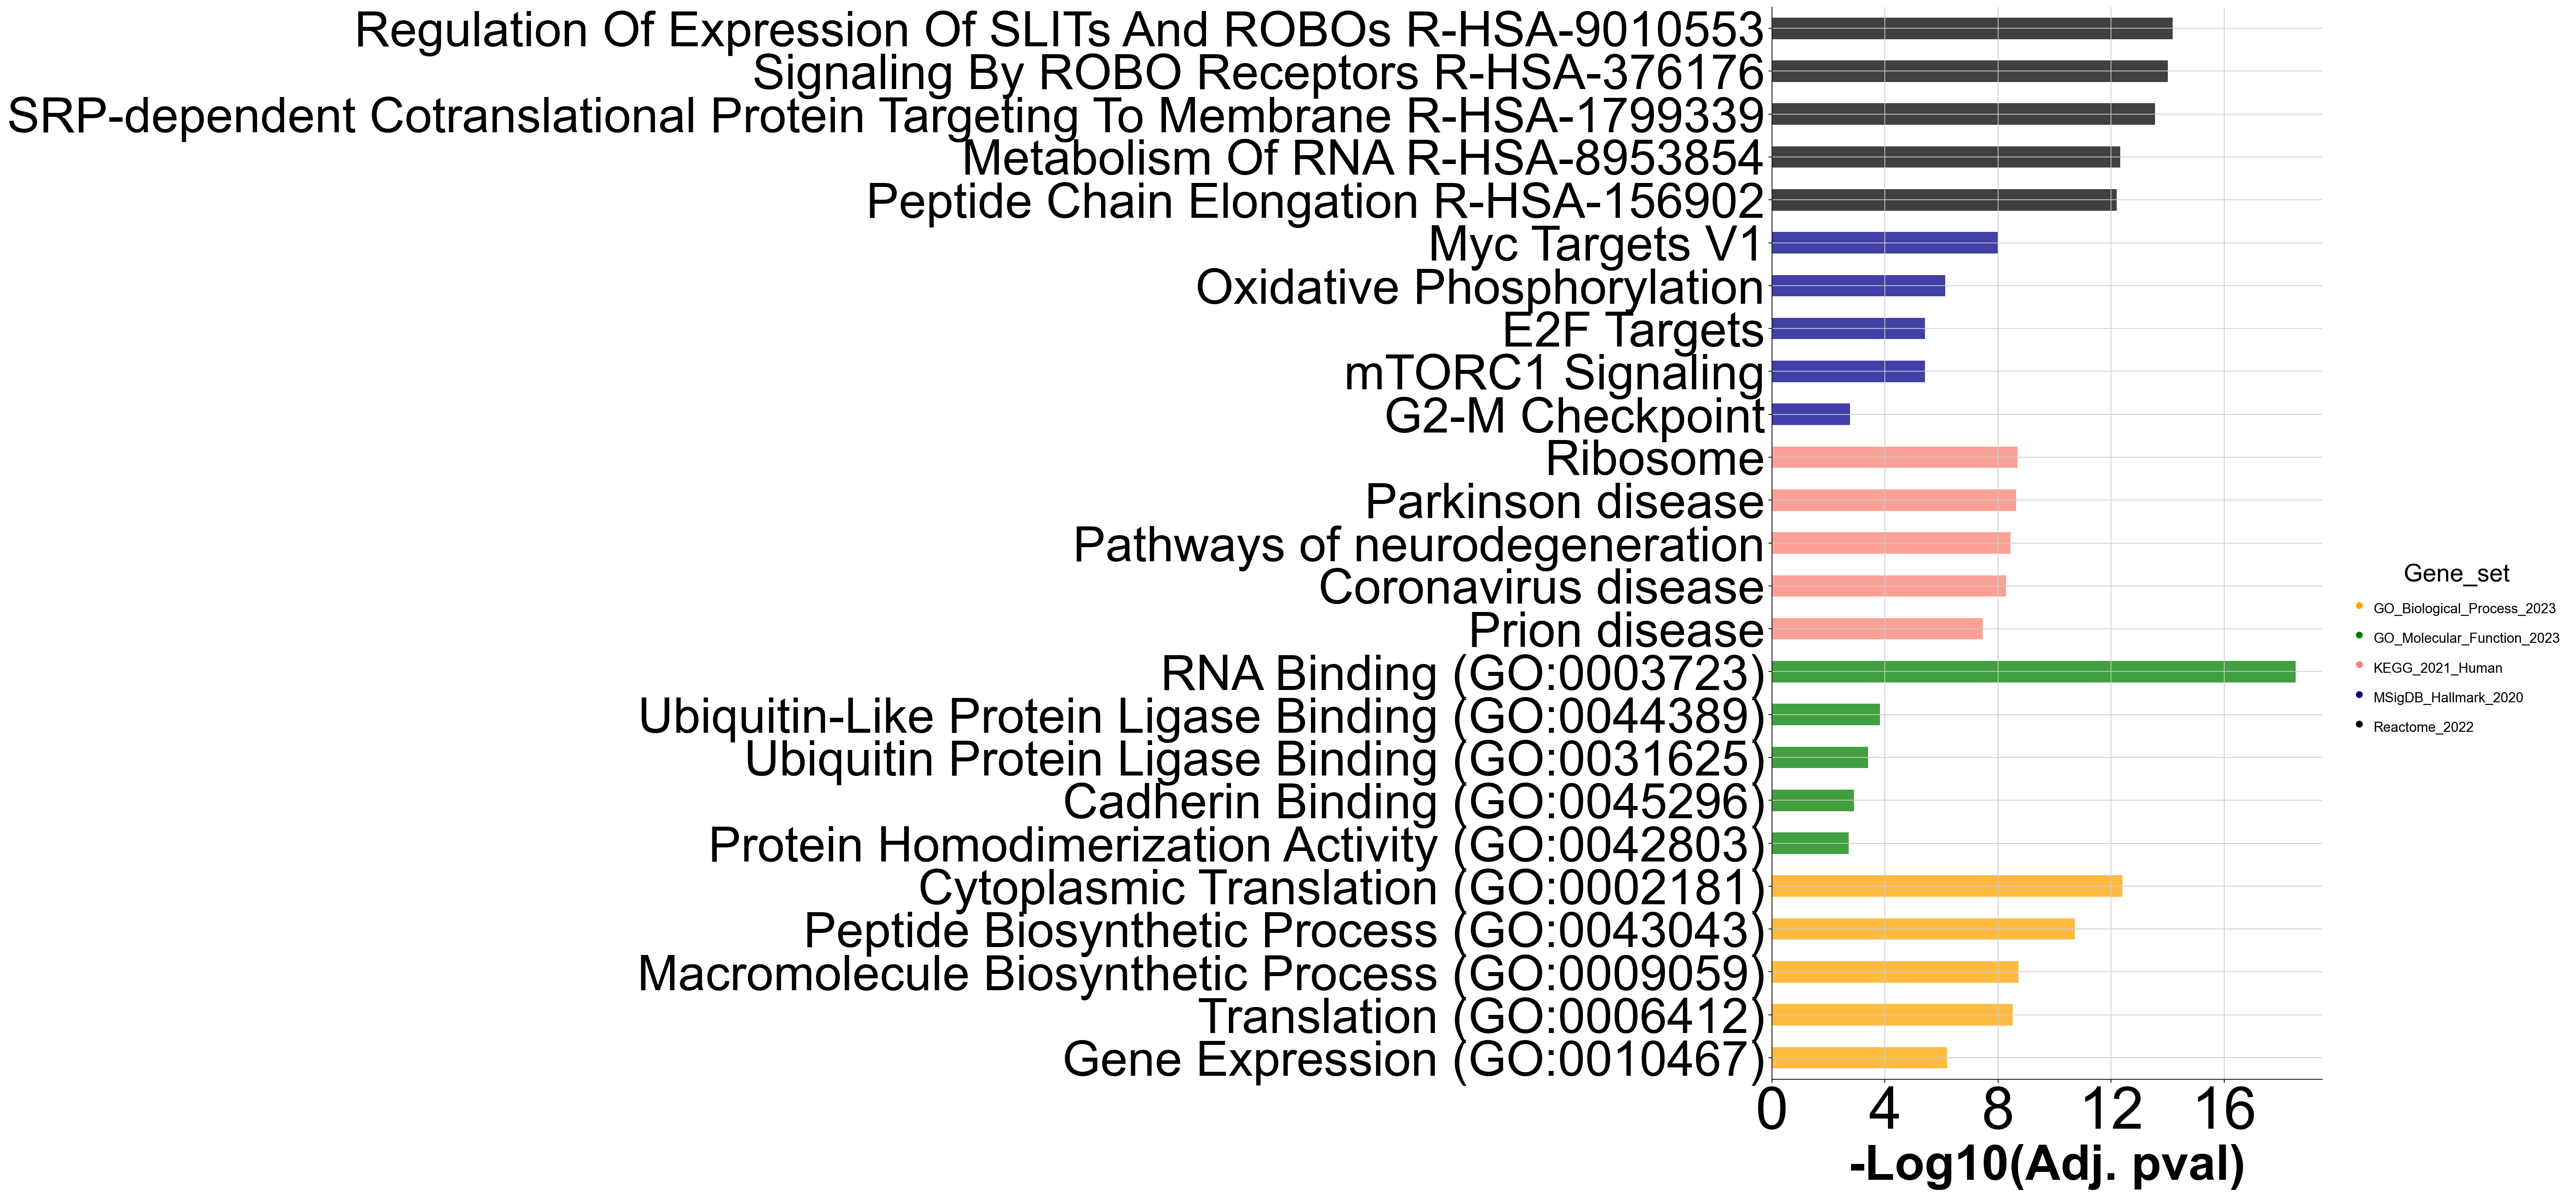

In [120]:
plt.rcParams.update({
    'axes.labelsize': 50, 
    'xtick.labelsize': 70, 
    'ytick.labelsize': 50})

ax = barplot(
    enr.results,
    column="Adjusted P-value",
    group='Gene_set',  
    size=50,
    top_term=5,
    figsize=(10, 20),
    color={
        'KEGG_2021_Human': 'salmon',
        'MSigDB_Hallmark_2020': 'darkblue',
        'GO_Molecular_Function_2023': 'green',
        'GO_Biological_Process_2023': 'orange',
        'Reactome_2022': 'black'})
ax.set_xlabel('-Log10(Adj. pval)', fontsize=50)

for tick in ax.get_xticklabels():
    tick.set_fontsize(60)
for tick in ax.get_yticklabels():
    tick.set_fontsize(50)
legend = ax.get_legend()
if legend:
    for text in legend.get_texts():
        text.set_fontsize(14)
plt.savefig('figures/80C_pathway.svg',bbox_inches='tight')
plt.show()

In [121]:
enr = gp.enrichr(gene_list=_4C_uplist,
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human','GO_Molecular_Function_2023',
                            'GO_Biological_Process_2023','Reactome_2022'],
                 organism='human',
                 outdir=None,
                )

In [122]:
enr.results['neg_log10(adj.pval)']=-1*np.log10(enr.results['Adjusted P-value'])

In [123]:
top_5_per_set = enr.results.groupby('Gene_set').apply(lambda x: x.nlargest(5, 'neg_log10(adj.pval)')).reset_index(drop=True)

In [124]:
top_5_per_set.to_csv('_up4C_pathways.csv')

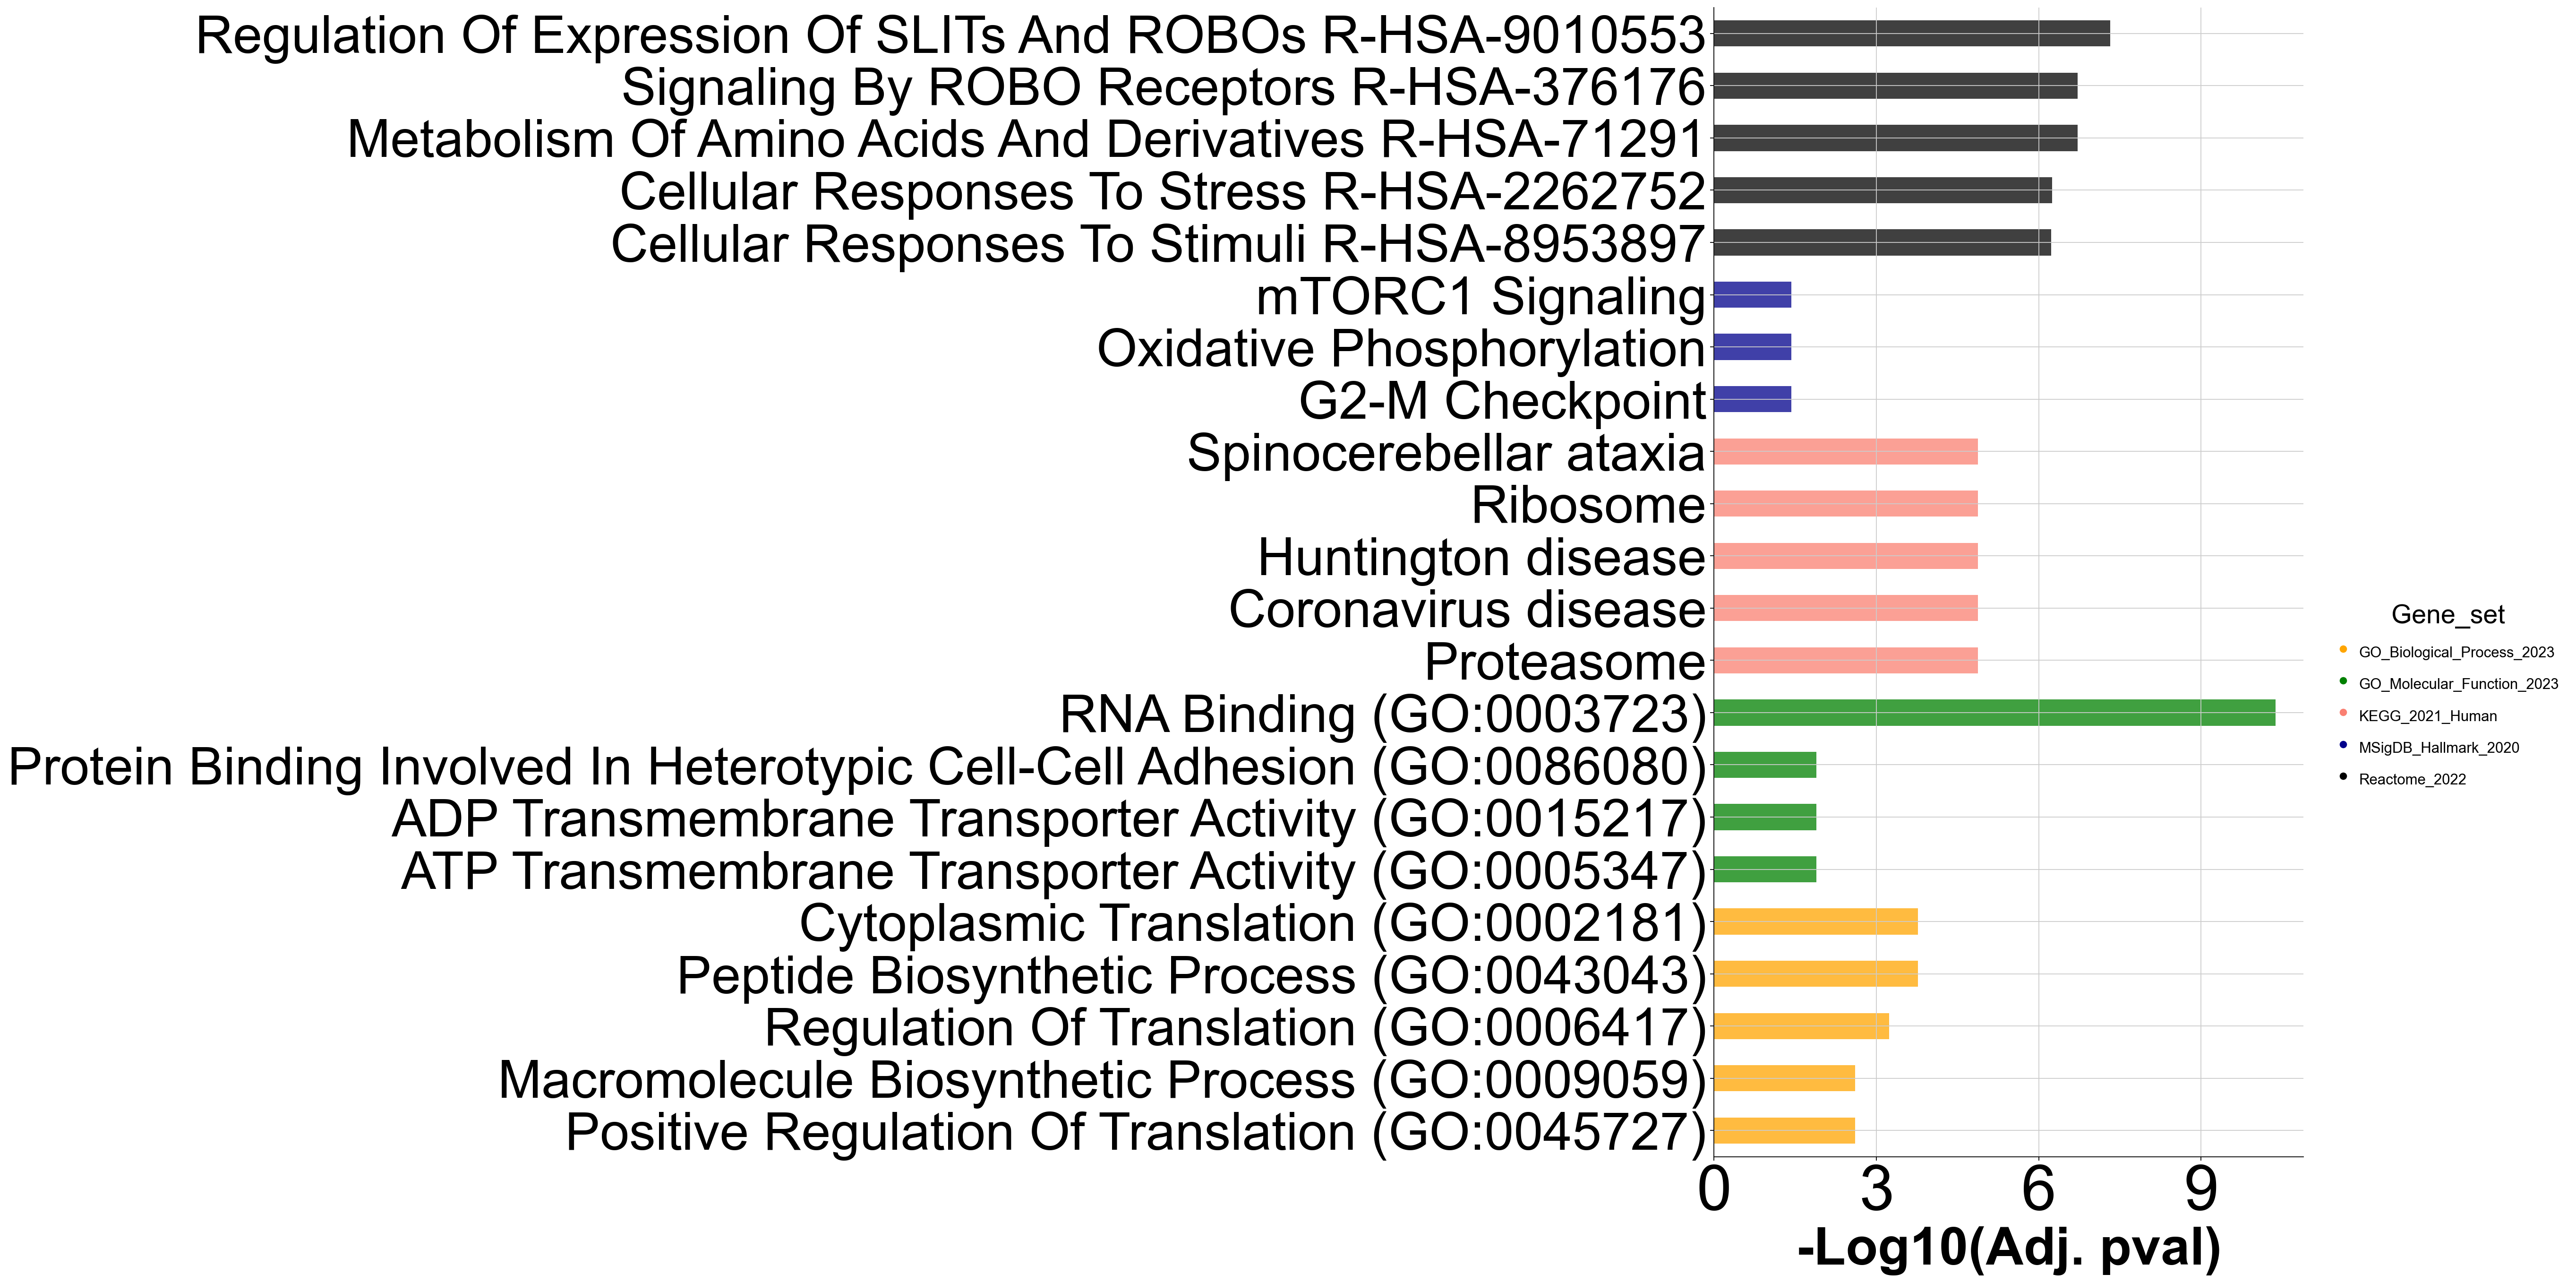

In [125]:
plt.rcParams.update({
    'axes.labelsize': 50, 
    'xtick.labelsize': 70,
    'ytick.labelsize': 50})
ax = barplot(
    enr.results,
    column="Adjusted P-value",
    group='Gene_set', 
    size=50,
    top_term=5,
    figsize=(10, 20),
    color={
        'KEGG_2021_Human': 'salmon',
        'MSigDB_Hallmark_2020': 'darkblue',
        'GO_Molecular_Function_2023': 'green',
        'GO_Biological_Process_2023': 'orange',
        'Reactome_2022': 'black'})
ax.set_xlabel('-Log10(Adj. pval)', fontsize=50)  
for tick in ax.get_xticklabels():
    tick.set_fontsize(60)
for tick in ax.get_yticklabels():
    tick.set_fontsize(50)
legend = ax.get_legend()
if legend:
    for text in legend.get_texts():
        text.set_fontsize(14)
plt.gcf().set_facecolor('white')
plt.savefig('figures/up4C_pathway.svg',bbox_inches='tight')
plt.show()

In [126]:
enr = gp.enrichr(gene_list=_80C_uplist, 
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human','GO_Molecular_Function_2023',
                            'GO_Biological_Process_2023','Reactome_2022'],
                 organism='human', 
                 outdir=None)

In [127]:
enr.results['neg_log10(adj.pval)']=-1*np.log10(enr.results['Adjusted P-value'])

In [128]:
top_5_per_set = enr.results.groupby('Gene_set').apply(lambda x: x.nlargest(5, 'neg_log10(adj.pval)')).reset_index(drop=True)

In [129]:
top_5_per_set.to_csv('_up80C_pathways.csv')

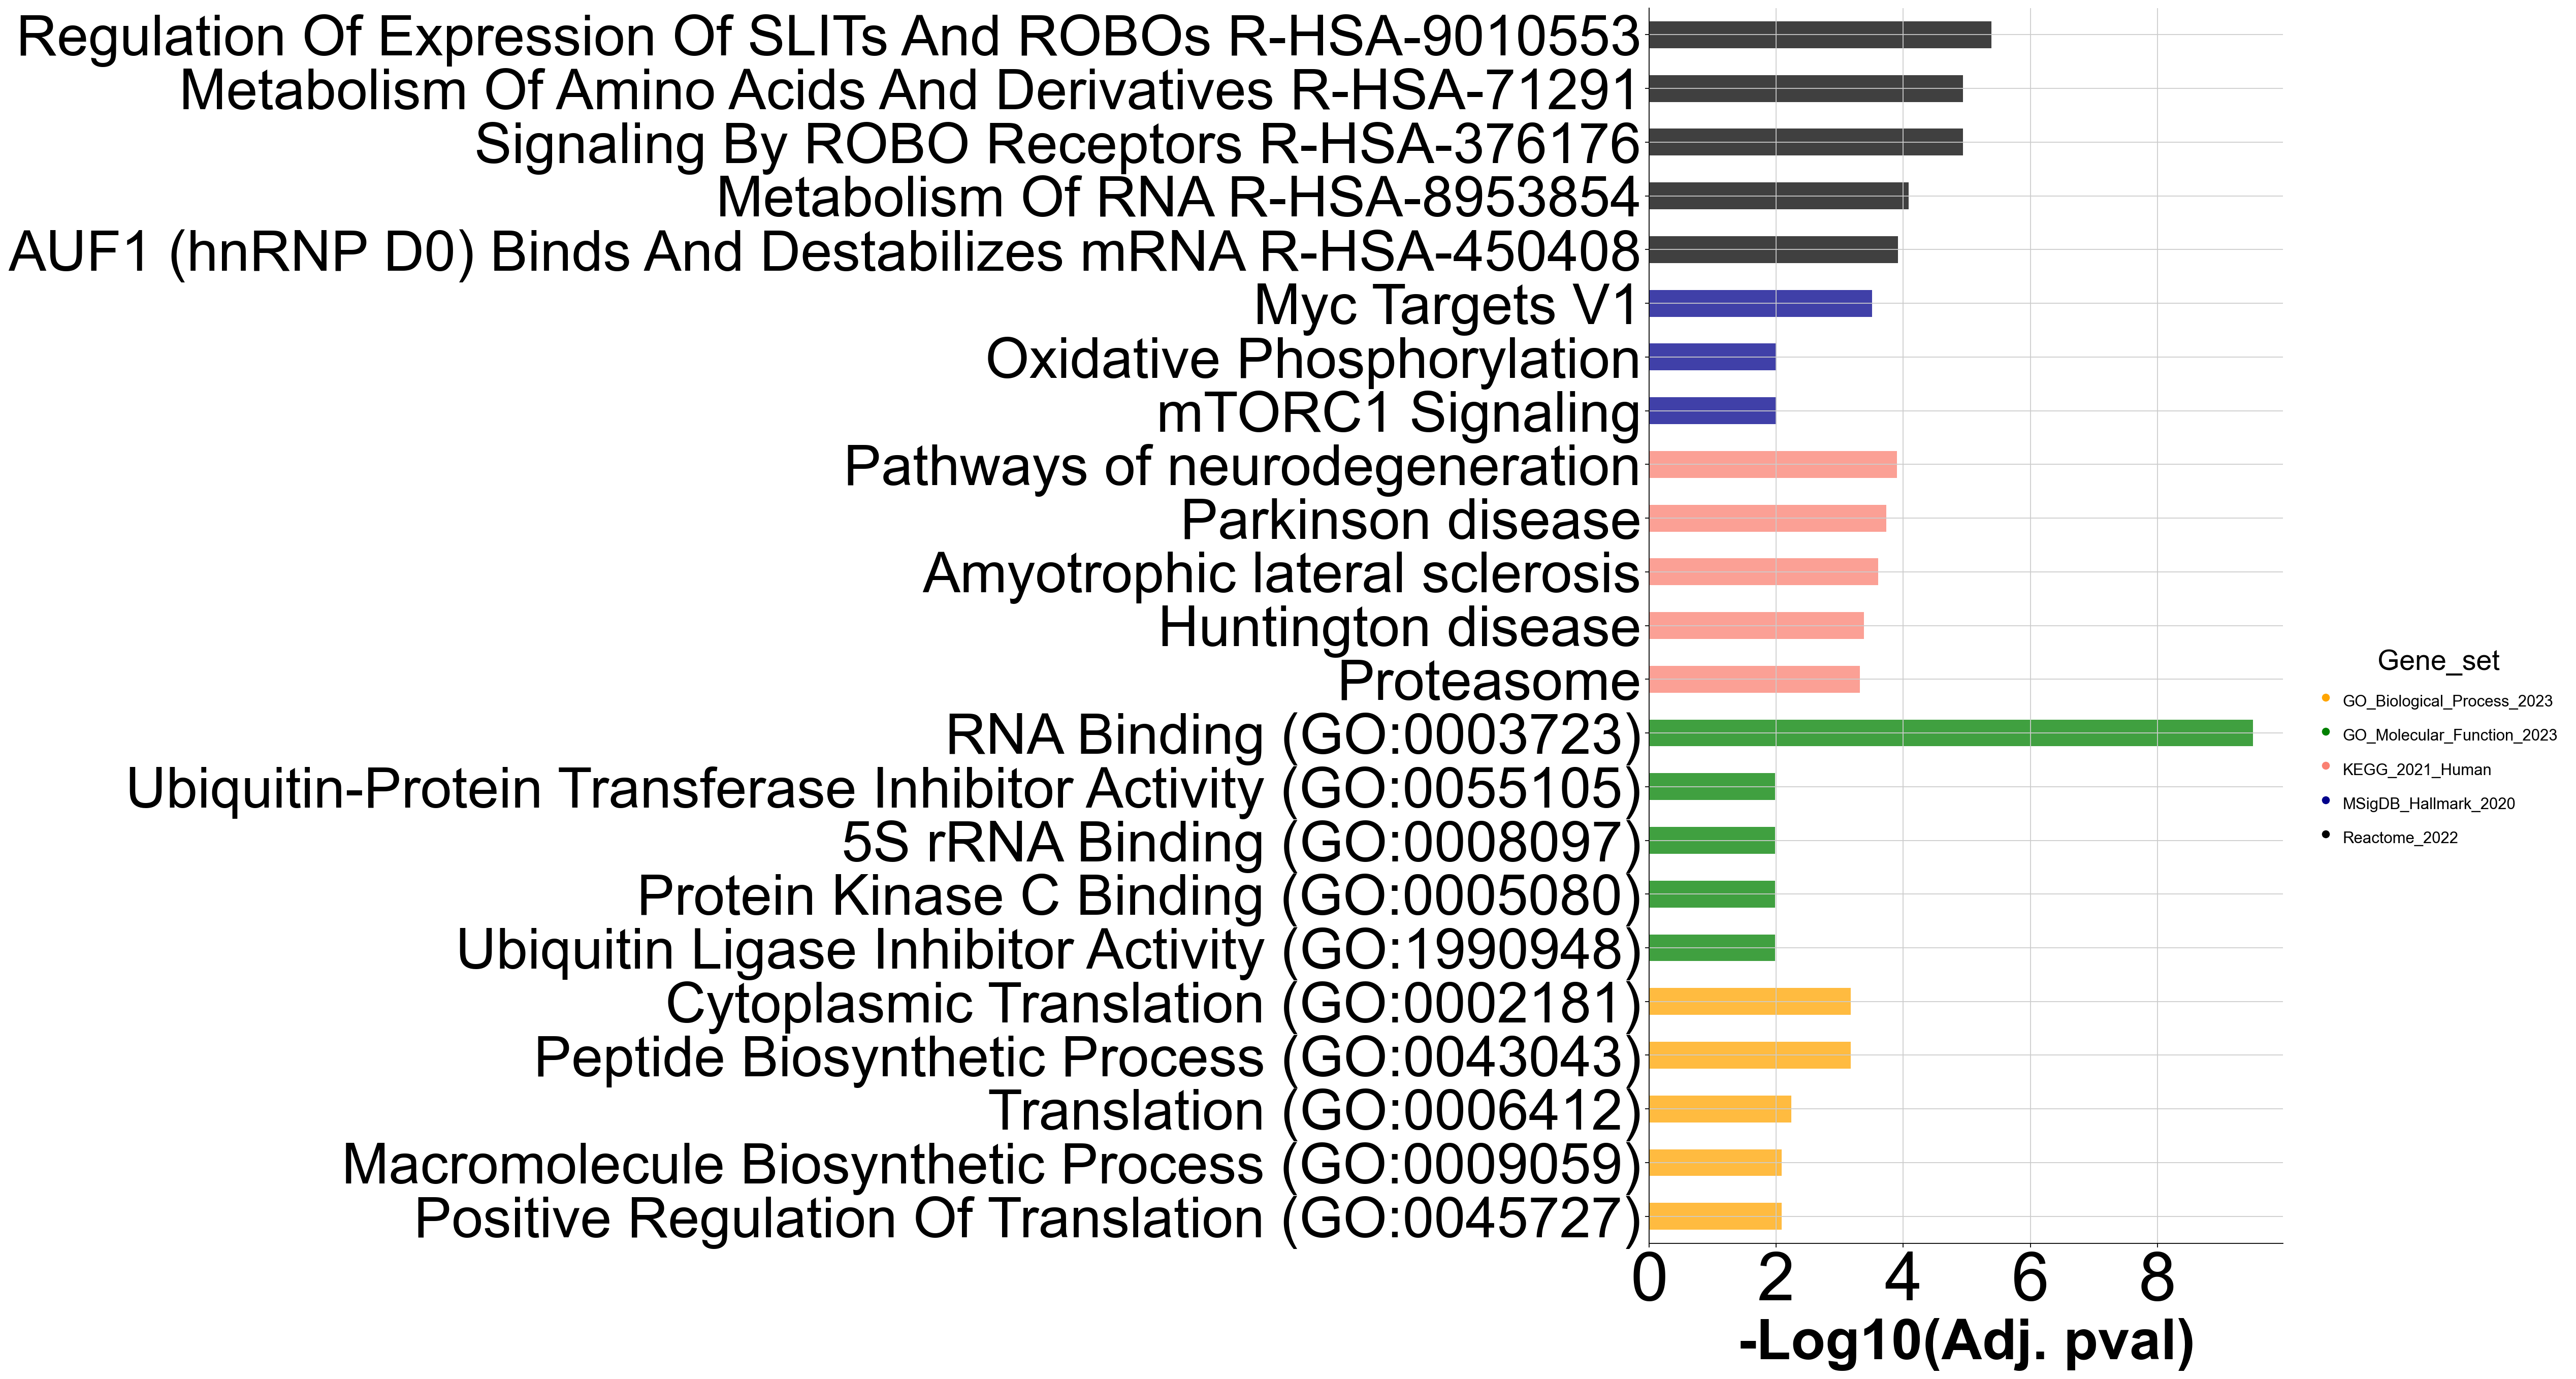

In [130]:
plt.rcParams.update({
    'axes.labelsize': 50,
    'xtick.labelsize': 70,
    'ytick.labelsize': 50})

ax = barplot(
    enr.results,
    column="Adjusted P-value",
    group='Gene_set',  # Set group, so you could do a multi-sample/library comparison
    size=50,
    top_term=5,
    figsize=(10, 20),
    color={
        'KEGG_2021_Human': 'salmon',
        'MSigDB_Hallmark_2020': 'darkblue',
        'GO_Molecular_Function_2023': 'green',
        'GO_Biological_Process_2023': 'orange',
        'Reactome_2022': 'black'})

ax.set_xlabel('-Log10(Adj. pval)', fontsize=50)  
for tick in ax.get_xticklabels():
    tick.set_fontsize(60)
for tick in ax.get_yticklabels():
    tick.set_fontsize(50)
legend = ax.get_legend()
if legend:
    for text in legend.get_texts():
        text.set_fontsize(14)
plt.gcf().set_facecolor('white')
plt.savefig('figures/up80C_pathway.svg',bbox_inches='tight')
plt.show()

#### Heatmaps

In [156]:
#all unique proteins in either list
overlap = set(_4_37_genelist+_80_37_genelist)

In [157]:
len(overlap)

160

In [173]:
oxphos=['TIMM13','CYC1','SDHA','SLC25A5','DLD','ATP5MF','SLC25A6','SLC25A3','MDH1','COX17','UQCRC1','TIMM13','VDAC3','ETFA','SDHA','DLD','ATP5MF',
'SLC25A6']

In [174]:
transl=['RPL5','RPS17','RPL21','RPL10','RPS5','RPL37A','RPLP2','RPL27','RPL15','RPL29','RPS27A','TUFM','RPL5','HARS1','RPL31','RPS5','RPL22','RPL11','RPL8','RPL10A','RPL18A','RPL37A','RACK1','RPLP2','RPL15','RPL29','RPS27A']

In [175]:
sel_transl = list(set(overlap) & set(transl))

In [176]:
sel_oxphos = list(set(overlap) & set(oxphos))

In [177]:
obs=data.obs['group'].reset_index()

In [178]:
tc_norm.reset_index(inplace=True)

In [179]:
merge=obs.merge(tc_norm, on='index',how='inner')

In [180]:
merge.set_index('index', inplace=True)

In [181]:
# Function to calculate the average of non-zero values
def avg_non_zero(series):
    non_zero_values = series[series != 0]
    if len(non_zero_values) > 0:
        return non_zero_values.mean()
    else:
        return np.nan

# Group by temperature and apply the avg_non_zero function
result = merge.groupby('group').apply(avg_non_zero)

C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_5856\2259555877.py:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return non_zero_values.mean()


In [201]:
result.to_csv('mean_quant.csv')

In [182]:
oxphos_result=result[sel_oxphos]

In [183]:
transl_result=result[sel_transl]

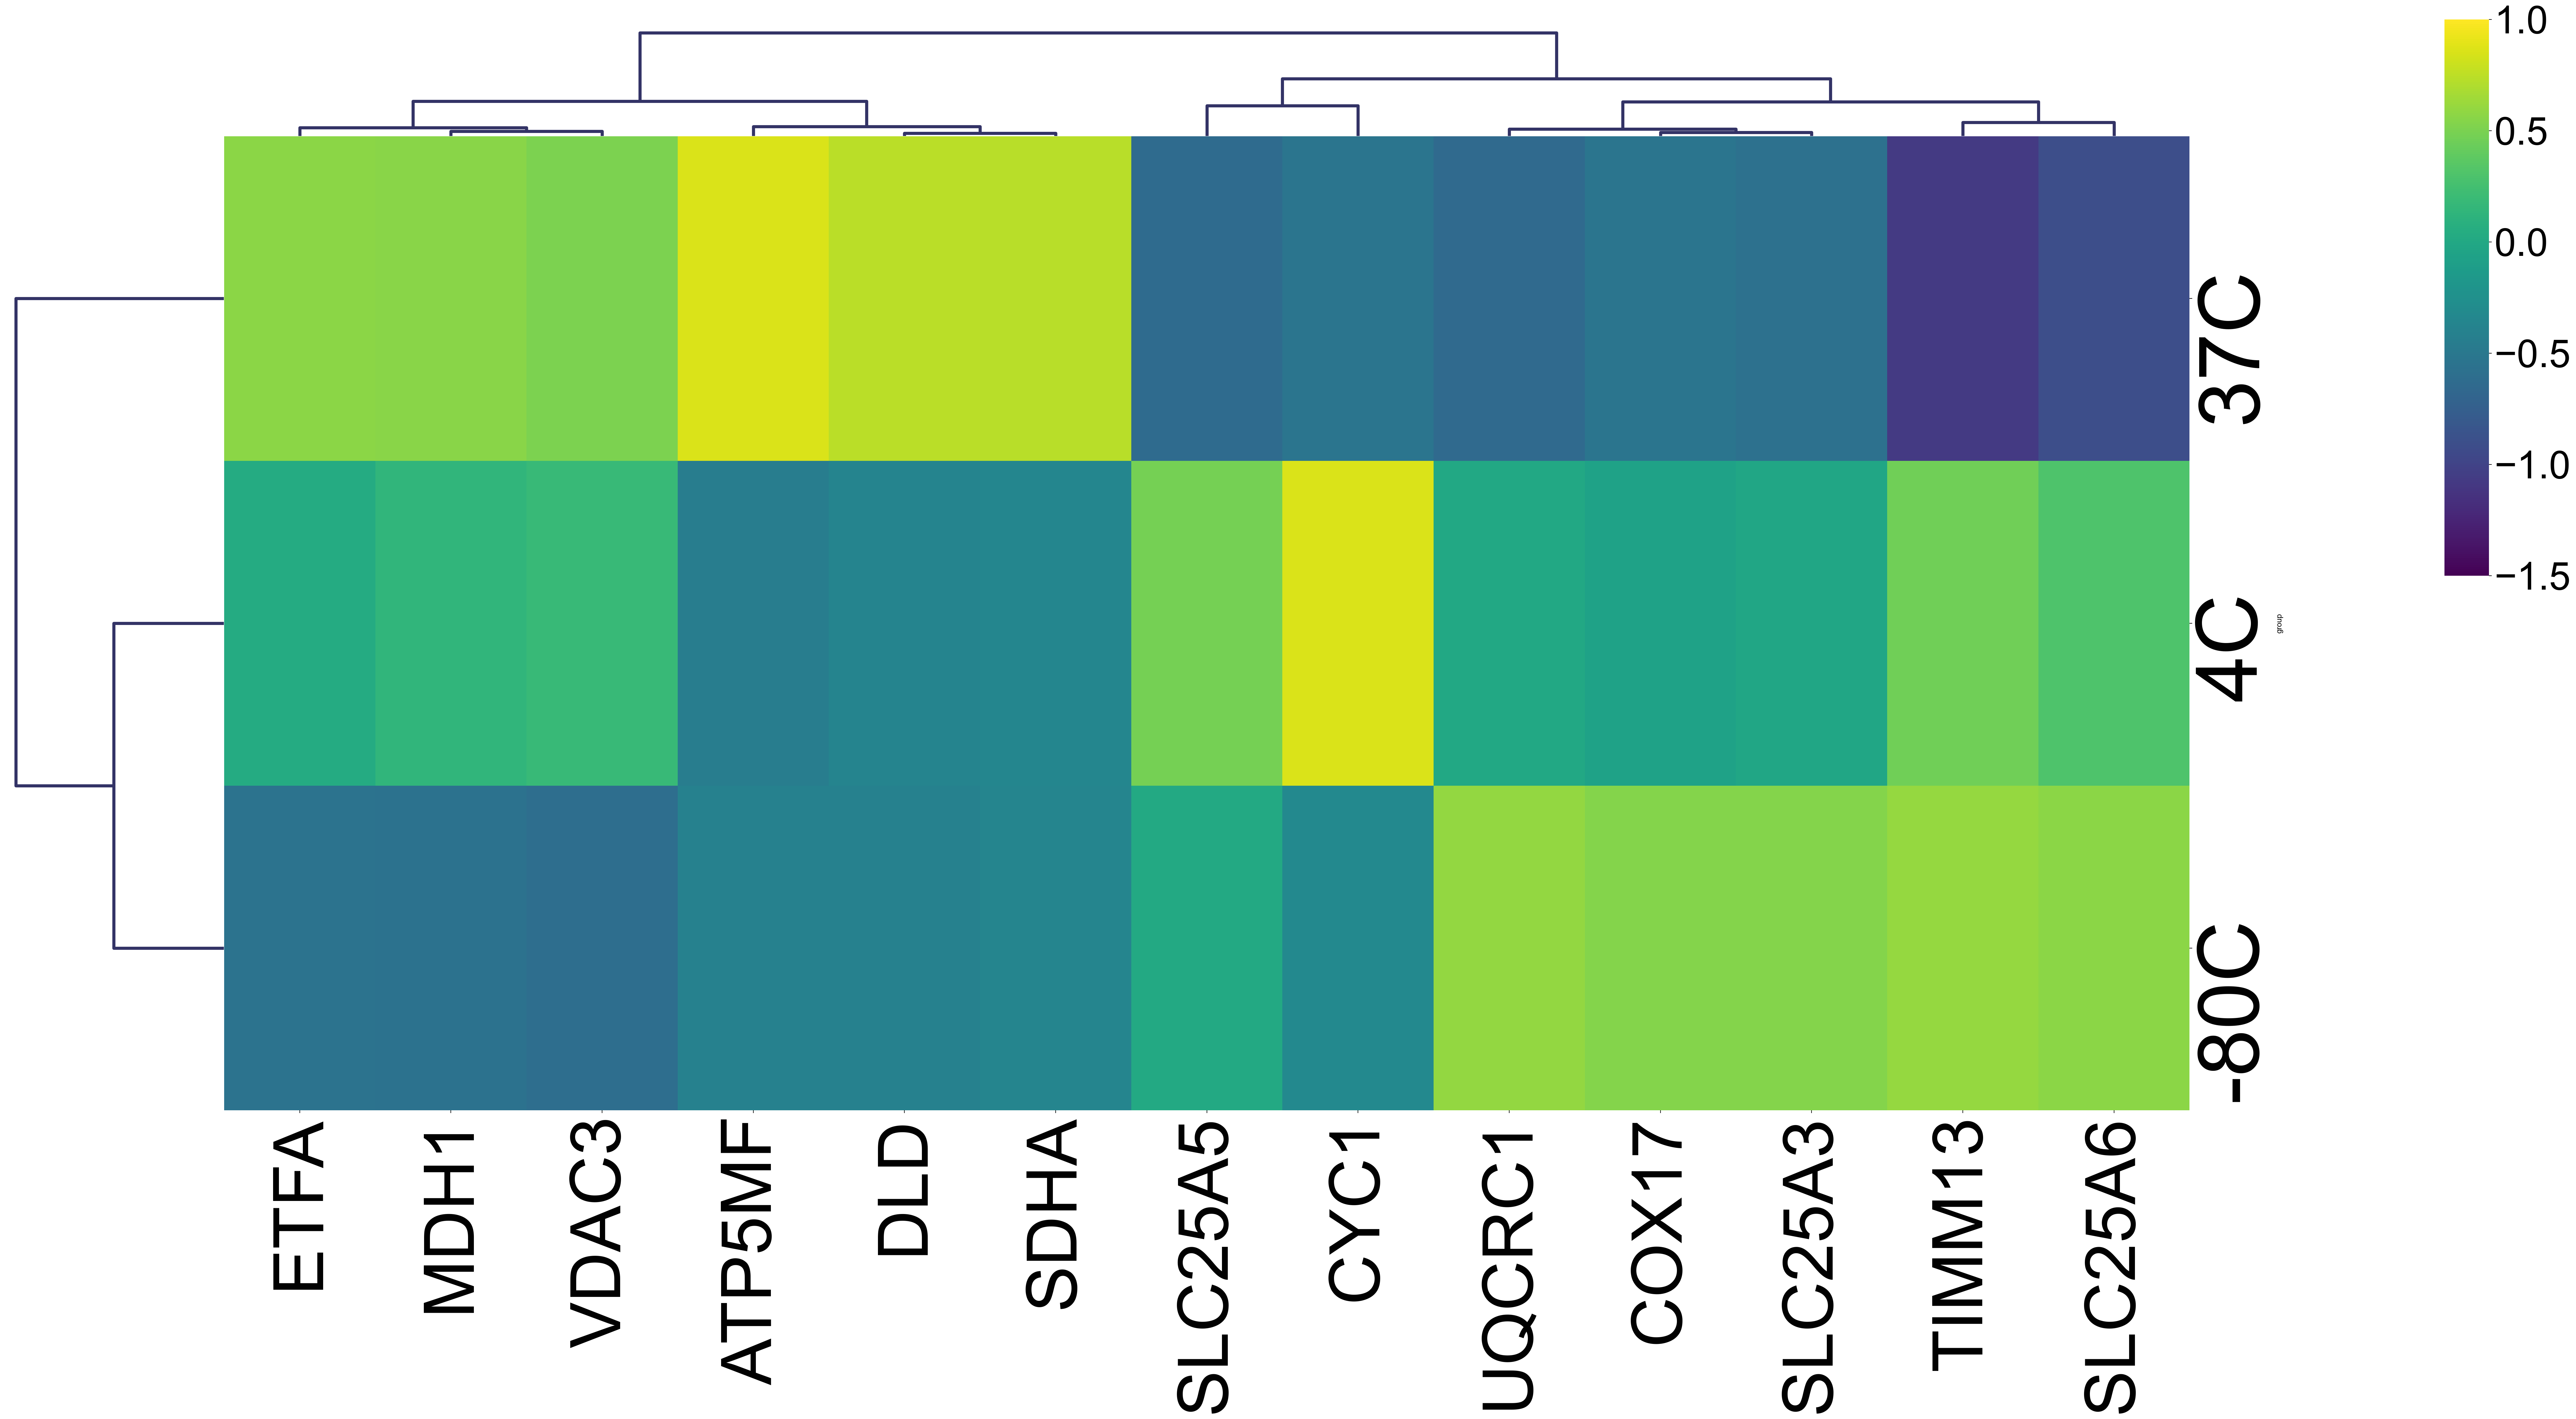

In [276]:
#sns.set(font_scale=2)
def link_color_func(k):
    return 'black'

ax=sns.clustermap(oxphos_result.fillna(0),
                  figsize=(40,20),
                  cbar_pos=(1.1, 0.5, 0.02, 0.5), 
                  row_cluster=True,
                  col_cluster=True,
                  #row_colors=['red', 'green', 'blue'],
                  annot=False,
                  cbar_kws={'shrink': 5},
                  tree_kws=dict(linewidths=4, colors=(0.2, 0.2, 0.4)),
                  dendrogram_ratio=(0.1,0.1), cmap='viridis',vmin=-1.5, vmax=1)
cbar = ax.cax
cbar.tick_params(labelsize=50)
sns.set(font_scale=3)
ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xticklabels(), fontsize=90, rotation=90)
ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), fontsize=110)
plt.savefig('figures/heatmap_oxphos.svg',bbox_inches='tight')
plt.show()

In [266]:
col_order = ax.dendrogram_col.reordered_ind
ordered_columns = oxphos_result.columns[col_order]

In [267]:
ordered_columns_lst=ordered_columns.to_list()

In [268]:
ordered_columns_lst.append('group')

In [269]:
melt=merge[ordered_columns_lst].melt(id_vars='group')

In [270]:
melt_nonzero=melt.loc[(melt != 0).all(axis=1)]

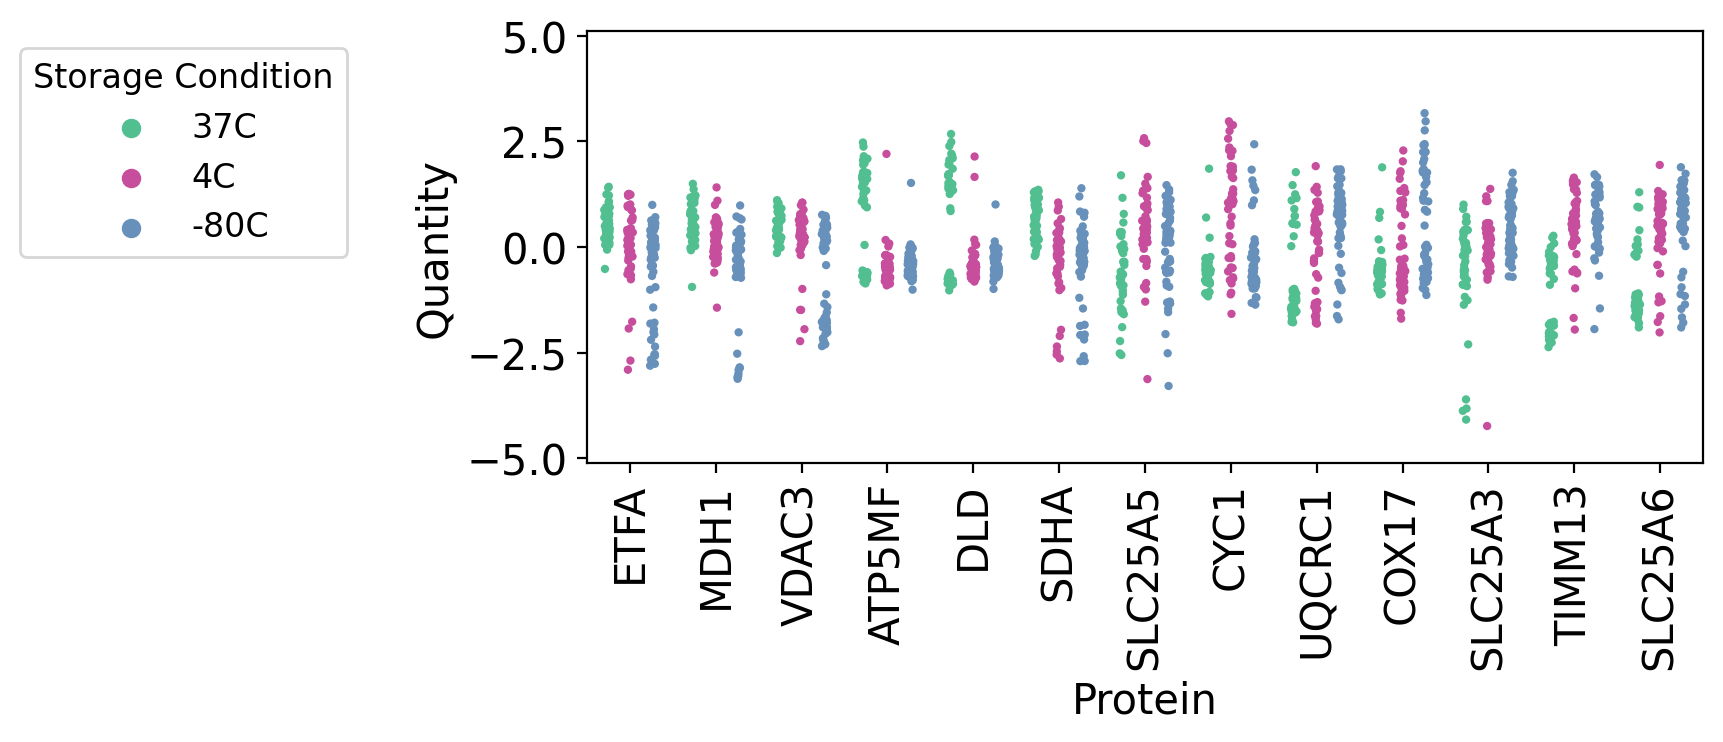

In [275]:
sns.reset_defaults()
plt.figure(figsize=(7.2,2.8))
custom_palette = ["#51BF90", "#C64E9C","#6791BA"]

ax=sns.stripplot(data=melt_nonzero, x="variable",y='value',hue='group',hue_order=["37C", "4C","-80C"], dodge=True, palette=custom_palette, size=3)

# Optionally, you can also set the axis label font sizes
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Quantity', fontsize=15)
ax.set_xlabel('Protein', fontsize=15)
# Set the background color of the plot area to white
ax.set_facecolor('white')

# Set the background color of the figure to white
plt.ylim(-5.1,5.1)
plt.gcf().set_facecolor('white')
plt.tick_params(axis='y', labelsize=15)
plt.tick_params(axis='x', labelsize=15)

plt.legend(title="Storage Condition", title_fontsize='large', fontsize="large", bbox_to_anchor=(-0.2, 1), loc='upper right')
plt.savefig('figures/stripplot_oxphos.svg',bbox_inches='tight')
#plt.tight_layout()
plt.show()

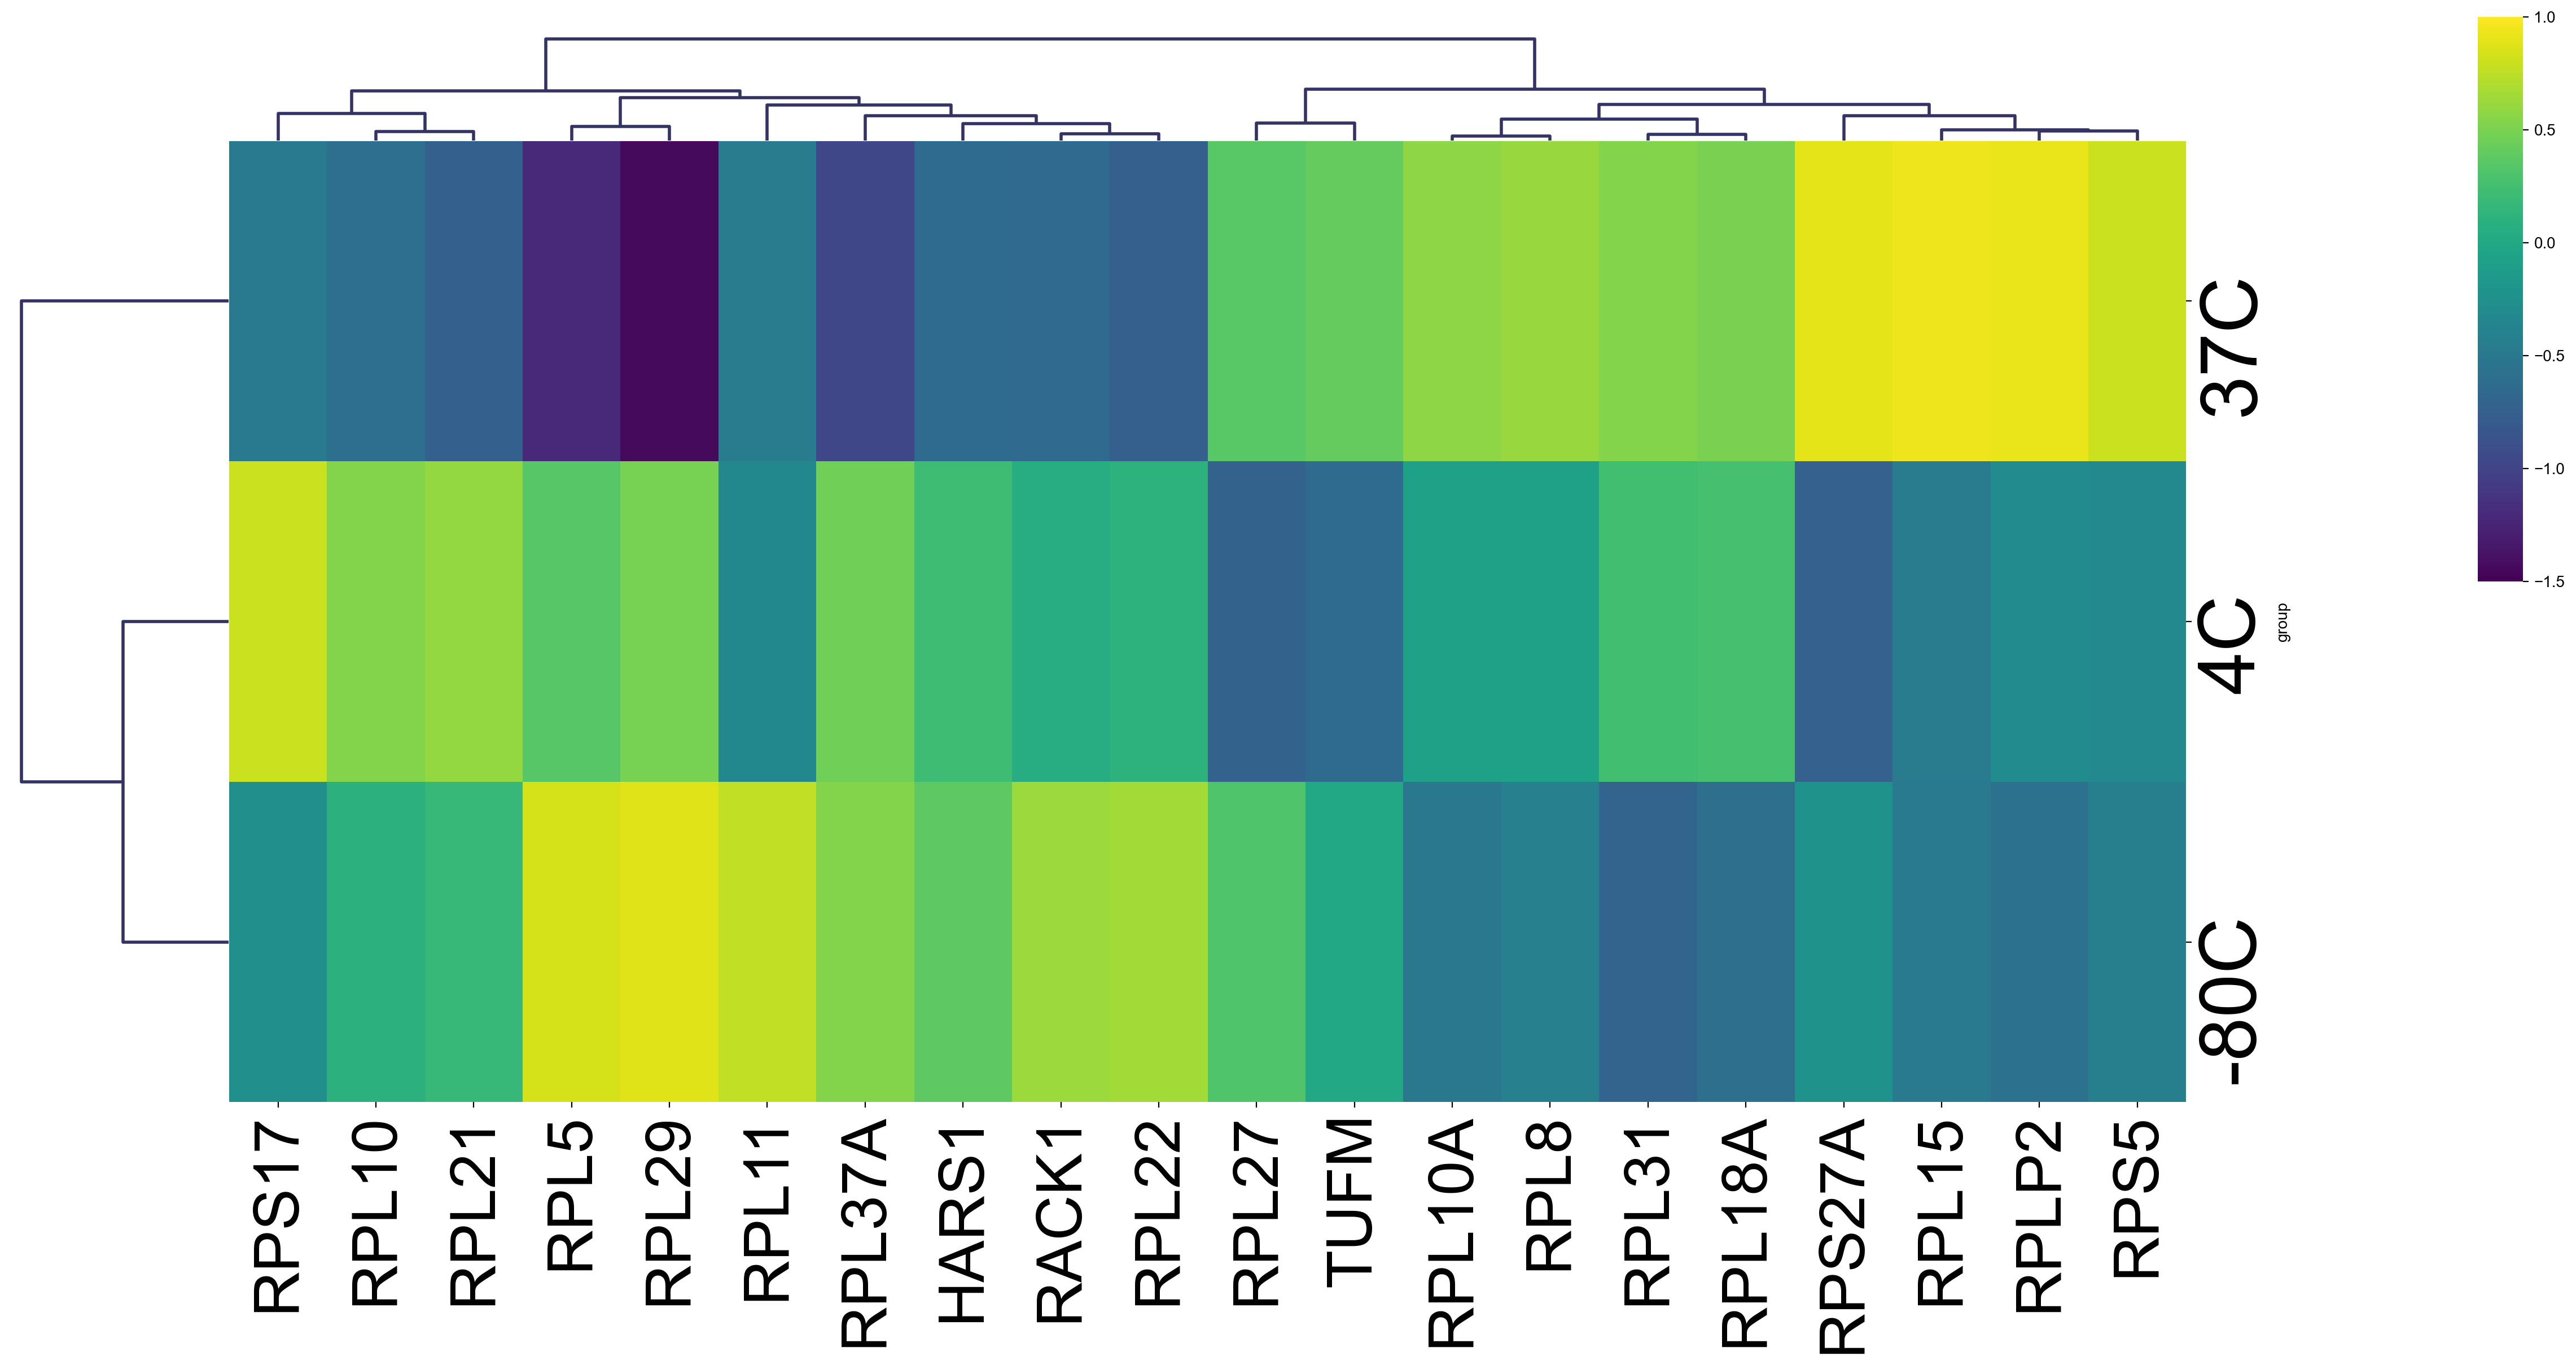

In [278]:
#sns.set(font_scale=2)
def link_color_func(k):
    return 'black'

ax=sns.clustermap(transl_result.fillna(0),
                  figsize=(20,10),
                  cbar_pos=(1.1, 0.5, 0.02, 0.5), 
                  row_cluster=True,
                  col_cluster=True,
                  #row_colors=['red', 'green', 'blue'],
                  annot=False,
                  cbar_kws={'shrink': 5},
                  tree_kws=dict(linewidths=2, colors=(0.2, 0.2, 0.4)),
                  dendrogram_ratio=(0.1,0.1), cmap='viridis',vmin=-1.5, vmax=1)

sns.set(font_scale=2)
ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xticklabels(), fontsize=40, rotation=90)
ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), fontsize=50)
plt.savefig('figures/heatmap_transl.svg',bbox_inches='tight')
plt.show()

In [279]:
col_order = ax.dendrogram_col.reordered_ind
ordered_columns = transl_result.columns[col_order]

In [280]:
ordered_columns_lst=ordered_columns.to_list()

In [281]:
ordered_columns_lst.append('group')

In [282]:
melt=merge[ordered_columns_lst].melt(id_vars='group')

In [283]:
melt_nonzero=melt.loc[(melt != 0).all(axis=1)]

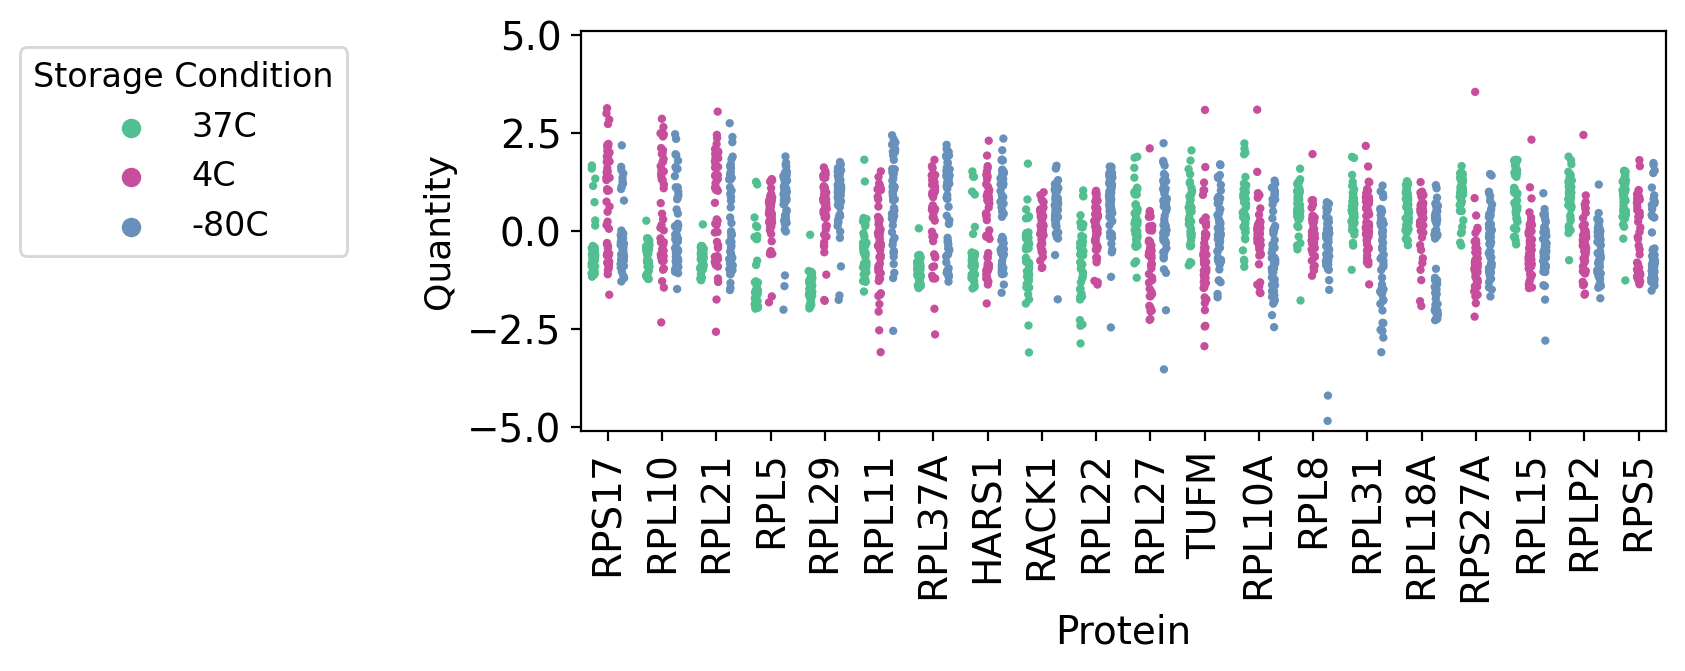

In [285]:
sns.reset_defaults()
plt.figure(figsize=(7,2.6))
custom_palette = ["#51BF90", "#C64E9C","#6791BA"]

ax=sns.stripplot(data=melt_nonzero, x="variable",y='value',hue='group',hue_order=["37C", "4C","-80C"], 
                 dodge=True, palette=custom_palette, size=3)

# Optionally, you can also set the axis label font sizes
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Quantity', fontsize=13)
ax.set_xlabel('Protein', fontsize=14)
# Set the background color of the plot area to white
ax.set_facecolor('white')

# Set the background color of the figure to white
plt.ylim(-5.1,5.1)
plt.gcf().set_facecolor('white')
plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)

plt.legend(title="Storage Condition", title_fontsize='large', fontsize="large", bbox_to_anchor=(-0.2, 1), loc='upper right')
plt.savefig('figures/stripplot_transl.svg',bbox_inches='tight')
#plt.tight_layout()
plt.show()